# 相关库导入和包加载，模型参数的配置

In [ ]:
import torch
import biom
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, f1_score, matthews_corrcoef, mean_absolute_error, r2_score, accuracy_score
from membed.Attention_embedding import load_data_imdb, DataLoader, TransformerEncoder, evaluate_auc_gpu, set_seed

membed 0.1.0 initialized.


In [ ]:
set_seed(11)
num_steps=600
p_drop=0.4
batch_size=6000
d_model=100
n_layers=1
n_heads=1
group = "group"

# 数据集大小对下游任务影响的分析

## 获取模型的预测结果

In [4]:

import os
import torch
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from sklearn import metrics
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, matthews_corrcoef
from biom import load_table
import re
 
results_base_dir = "Data/pretraining_datasize/result"
original_data_base_dir = "Data/disease_data"

# --- Initialize results container ---
results = {
    'disease': [], 'dataset': [], 'datasize': [], 'test_study': [], 'auc': [], 'f1': [],
    'mcc': [], 'acc': [], 'confusion_matrix': []
}
 
def evaluate_auc_gpu(Y, prob):
    """综合性能评估函数"""
    Y = Y.numpy().astype('int')
    prob = prob.cpu().detach().numpy()
    
    # 计算ROC曲线
    fpr, tpr, _ = metrics.roc_curve(Y, prob)
    roc_auc = metrics.auc(fpr, tpr)
    
    # 计算PR曲线
    precision, recall, _ = metrics.precision_recall_curve(Y, prob)
    pr_auc = metrics.auc(recall, precision)
    
    # 计算分类指标
    y_pred = (prob > 0.5).astype(int)
    cm = confusion_matrix(Y, y_pred)
    f1 = f1_score(Y, y_pred, average='macro')
    acc = accuracy_score(Y, y_pred)
    mcc = matthews_corrcoef(Y, y_pred)
    
    return roc_auc, pr_auc, f1, mcc, acc, cm, fpr, tpr
 
def process_biom_table(biom_table, metadata_path):
    """模拟数据预处理函数（需根据实际需求实现）"""
    # 这里应包含特征工程、标准化等处理逻辑
    return {
        'features': np.random.rand(10, 100),  # 示例数据
        'labels': np.random.randint(0, 2, 10)
    }
 
def load_model(model_path):
    """模拟模型加载函数"""
    return torch.load(model_path, map_location=torch.device('cpu'))
 
def save_results(disease, dataset, datasize, study, roc_auc, pr_auc, f1, mcc, acc, cm, fpr, tpr, study_results_dir):
    """Saves evaluation metrics and ROC curve data (Simplified: removed print)"""
    results['disease'].append(disease)
    results['dataset'].append(dataset)
    results['datasize'].append(datasize)
    results['test_study'].append(study)
    results['auc'].append(roc_auc)
    results['f1'].append(f1)
    results['mcc'].append(mcc)
    results['acc'].append(acc)
    results['confusion_matrix'].append(np.array2string(cm).replace('\n', ''))

    roc_df = pd.DataFrame({'FPR': fpr, 'TPR': tpr})
    os.makedirs(study_results_dir, exist_ok=True)
    roc_output_path = os.path.join(study_results_dir, "roc_curve_eval.csv")
    roc_df.to_csv(roc_output_path, index=False)

# --- Main Processing Loop (Simplified) ---
print(f"Starting evaluation process (simplified)...")

# Loop 1: Diseases
for disease_name in os.listdir(results_base_dir):
    disease_path = os.path.join(results_base_dir, disease_name)
    # Removed isdir check
    if not os.path.isdir(disease_path):
        continue

    metadata_path = os.path.join(original_data_base_dir, disease_name, "metadata.tsv")
    # Removed metadata exists check

    if disease_name !="IBD" : continue 

    # Loop 2: DataSize Directories (e.g., datasize_result_1)
    for data_size_dirname in os.listdir(disease_path):
        data_size_dir_path = os.path.join(disease_path, data_size_dirname)
        # Removed isdir check and startswith check

        # --- Extract 'dataset' number (Simplified: no error handling) ---
        dataset_match = re.search(r'datasize_result_(\d+)', data_size_dirname)
        if not dataset_match: continue # Basic check to skip non-matching dirs
        dataset_num = int(dataset_match.group(1))

        # Loop 3: Embedding Short Name Directories (e.g., subset_table_1w)
        for embedding_short_name in os.listdir(data_size_dir_path):
            embedding_dir_path = os.path.join(data_size_dir_path, embedding_short_name)
            # Removed isdir check and startswith check

            # --- Extract 'datasize' string (Simplified: no error handling) ---
            datasize_match = re.search(r'subset_table_([^_]+)', embedding_short_name)
            if not datasize_match: continue # Basic check to skip non-matching dirs
            datasize_str = datasize_match.group(1) # e.g., "1w", "16w"

            # Loop 4: Study IDs
            for study_id in os.listdir(embedding_dir_path):
                study_path = os.path.join(embedding_dir_path, study_id)
                # Removed isdir check

                # Define paths
                study_results_dir = study_path
                model_path = os.path.join(study_results_dir, 'attention_loo.pt')
                train_biom_path = os.path.join(original_data_base_dir, disease_name, study_id, "train_loo.biom")
                test_biom_path = os.path.join(original_data_base_dir, disease_name, study_id, "test_loo.biom")

                # Removed file existence checks for model and data

                # Load Data (using placeholders - replace with your actual loading)
                train_data = load_data_imdb(train_biom_path, metadata_path, group,'sample', num_steps)
                test_data = load_data_imdb(test_biom_path, metadata_path, group,'sample', num_steps)

                # --- Access fid_dict (Simplified: assumes method/attribute exists) ---
                # Adapt based on your actual Dataset object structure
                fid_dict = train_data() # Or train_data.fid_dict

                # Removed check for fid_dict existence and '<pad>' token

                # Create DataLoaders
                test_iter = DataLoader(test_data, batch_size=batch_size, shuffle=False)

                # Initialize Model (using placeholder - replace with your actual model)
                otu_size = len(fid_dict)
                net = TransformerEncoder(otu_size=otu_size,
                                        seq_len=num_steps + 1, # Check if correct seq_len
                                        d_model=d_model,
                                        n_layers=n_layers,
                                        n_heads=n_heads,
                                        p_drop=p_drop,
                                        pad_id=fid_dict['<pad>'])

                # Load Model Weights
                net.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
                net.eval() # Set model to evaluation mode

                # --- Perform Evaluation ---
                all_preds = []
                all_labels = []
                with torch.no_grad():
                    for i, (features, abundance, group_labels, mask) in enumerate(test_iter):
                         pred, _ = net(features, abundance, mask)
                         all_preds.append(pred)
                         all_labels.append(group_labels)

                # Removed check for empty predictions

                final_preds = torch.cat(all_preds, dim=0)
                final_labels = torch.cat(all_labels, dim=0)

                # Calculate metrics
                roc_auc, pr_auc, f1, mcc, acc, cm, fpr, tpr = evaluate_auc_gpu(final_labels, final_preds)
                
                

                # Save results for this study
                save_results(disease_name, dataset_num, datasize_str, study_id,
                             roc_auc, pr_auc, f1, mcc, acc, cm, fpr, tpr,
                             study_results_dir)
                print(f"Finished evaluation for study: {study_results_dir}")

# --- Final Summary ---
print(f"Evaluation process finished.")
summary_df = pd.DataFrame(results)
summary_path = os.path.join(results_base_dir, "summary_ROC_results_datasize_IBD.csv")
summary_df.to_csv(summary_path, index=False)
print(f"Summary results saved to: {summary_path}")


Starting evaluation process (simplified)...
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_1/subset_table_8w/qiita_2538
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_1/subset_table_8w/PRJNA324147
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_1/subset_table_8w/qiita_1629


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_1/subset_table_8w/PRJNA450340
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_1/subset_table_8w/RISK_PRISM_f


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_1/subset_table_8w/PRJNA368966
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_1/subset_table_8w/PRJNA422193
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_1/subset_table_8w/PRJNA431126
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_1/subset_table_16w/qiita_2538


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_1/subset_table_16w/PRJNA324147


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_1/subset_table_16w/qiita_1629


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_1/subset_table_16w/PRJNA450340


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_1/subset_table_16w/RISK_PRISM_f


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_1/subset_table_16w/PRJNA368966
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_1/subset_table_16w/PRJNA422193


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_1/subset_table_16w/PRJNA431126
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_1/subset_table_4w/qiita_2538


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_1/subset_table_4w/PRJNA324147
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_1/subset_table_4w/qiita_1629
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_1/subset_table_4w/PRJNA450340
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_1/subset_table_4w/RISK_PRISM_f


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_1/subset_table_4w/PRJNA368966


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_1/subset_table_4w/PRJNA422193
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_1/subset_table_4w/PRJNA431126
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_1/subset_table_2k/qiita_2538
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_1/subset_table_2k/PRJNA324147
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_1/subset_table_2k/qiita_1629


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_1/subset_table_2k/PRJNA450340
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_1/subset_table_2k/RISK_PRISM_f
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_1/subset_table_2k/PRJNA368966
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_1/subset_table_2k/PRJNA422193


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_1/subset_table_2k/PRJNA431126


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_1/subset_table_2w/qiita_2538


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_1/subset_table_2w/PRJNA324147
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_1/subset_table_2w/qiita_1629


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_1/subset_table_2w/PRJNA450340


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_1/subset_table_2w/RISK_PRISM_f


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_1/subset_table_2w/PRJNA368966


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_1/subset_table_2w/PRJNA422193


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_1/subset_table_2w/PRJNA431126


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_1/subset_table_1w/qiita_2538
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_1/subset_table_1w/PRJNA324147
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_1/subset_table_1w/qiita_1629
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_1/subset_table_1w/PRJNA450340
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_1/subset_table_1w/RISK_PRISM_f
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_1/subset_table_1w/PRJNA368966
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_1/subset_table_1w/PRJNA422193
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_1/subset_table_1w/PRJNA431126


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_1/subset_table_5k/qiita_2538
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_1/subset_table_5k/PRJNA324147
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_1/subset_table_5k/qiita_1629
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_1/subset_table_5k/PRJNA450340
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_1/subset_table_5k/RISK_PRISM_f


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_1/subset_table_5k/PRJNA368966
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_1/subset_table_5k/PRJNA422193


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_1/subset_table_5k/PRJNA431126


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_1/subset_table_1k/qiita_2538
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_1/subset_table_1k/PRJNA324147
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_1/subset_table_1k/qiita_1629
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_1/subset_table_1k/PRJNA450340
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_1/subset_table_1k/RISK_PRISM_f
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_1/subset_table_1k/PRJNA368966
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_1/subset_table_1k/PRJNA422193


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_1/subset_table_1k/PRJNA431126
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_2/subset_table_8w/qiita_2538
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_2/subset_table_8w/PRJNA324147
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_2/subset_table_8w/qiita_1629


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_2/subset_table_8w/PRJNA450340
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_2/subset_table_8w/RISK_PRISM_f
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_2/subset_table_8w/PRJNA368966
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_2/subset_table_8w/PRJNA422193


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_2/subset_table_8w/PRJNA431126


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_2/subset_table_16w/qiita_2538


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_2/subset_table_16w/PRJNA324147
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_2/subset_table_16w/qiita_1629


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_2/subset_table_16w/PRJNA450340
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_2/subset_table_16w/RISK_PRISM_f
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_2/subset_table_16w/PRJNA368966


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_2/subset_table_16w/PRJNA422193


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_2/subset_table_16w/PRJNA431126
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_2/subset_table_4w/qiita_2538
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_2/subset_table_4w/PRJNA324147
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_2/subset_table_4w/qiita_1629


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_2/subset_table_4w/PRJNA450340
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_2/subset_table_4w/RISK_PRISM_f
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_2/subset_table_4w/PRJNA368966
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_2/subset_table_4w/PRJNA422193
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_2/subset_table_4w/PRJNA431126


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_2/subset_table_2k/qiita_2538
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_2/subset_table_2k/PRJNA324147
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_2/subset_table_2k/qiita_1629
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_2/subset_table_2k/PRJNA450340
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_2/subset_table_2k/RISK_PRISM_f
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_2/subset_table_2k/PRJNA368966
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_2/subset_table_2k/PRJNA422193


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_2/subset_table_2k/PRJNA431126
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_2/subset_table_2w/qiita_2538


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_2/subset_table_2w/PRJNA324147
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_2/subset_table_2w/qiita_1629


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_2/subset_table_2w/PRJNA450340
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_2/subset_table_2w/RISK_PRISM_f
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_2/subset_table_2w/PRJNA368966
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_2/subset_table_2w/PRJNA422193


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_2/subset_table_2w/PRJNA431126
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_2/subset_table_1w/qiita_2538
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_2/subset_table_1w/PRJNA324147
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_2/subset_table_1w/qiita_1629


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_2/subset_table_1w/PRJNA450340
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_2/subset_table_1w/RISK_PRISM_f
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_2/subset_table_1w/PRJNA368966
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_2/subset_table_1w/PRJNA422193


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_2/subset_table_1w/PRJNA431126


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_2/subset_table_5k/qiita_2538
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_2/subset_table_5k/PRJNA324147
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_2/subset_table_5k/qiita_1629
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_2/subset_table_5k/PRJNA450340
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_2/subset_table_5k/RISK_PRISM_f
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_2/subset_table_5k/PRJNA368966
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_2/subset_table_5k/PRJNA422193


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_2/subset_table_5k/PRJNA431126
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_2/subset_table_1k/qiita_2538
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_2/subset_table_1k/PRJNA324147
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_2/subset_table_1k/qiita_1629


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_2/subset_table_1k/PRJNA450340
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_2/subset_table_1k/RISK_PRISM_f


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_2/subset_table_1k/PRJNA368966
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_2/subset_table_1k/PRJNA422193


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_2/subset_table_1k/PRJNA431126
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_5/subset_table_8w/qiita_2538
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_5/subset_table_8w/PRJNA324147
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_5/subset_table_8w/qiita_1629


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_5/subset_table_8w/PRJNA450340
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_5/subset_table_8w/RISK_PRISM_f
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_5/subset_table_8w/PRJNA368966
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_5/subset_table_8w/PRJNA422193
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_5/subset_table_8w/PRJNA431126
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_5/subset_table_16w/qiita_2538


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_5/subset_table_16w/PRJNA324147


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_5/subset_table_16w/qiita_1629


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_5/subset_table_16w/PRJNA450340


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_5/subset_table_16w/RISK_PRISM_f
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_5/subset_table_16w/PRJNA368966


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_5/subset_table_16w/PRJNA422193


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_5/subset_table_16w/PRJNA431126


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_5/subset_table_4w/qiita_2538


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_5/subset_table_4w/PRJNA324147
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_5/subset_table_4w/qiita_1629


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_5/subset_table_4w/PRJNA450340
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_5/subset_table_4w/RISK_PRISM_f


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_5/subset_table_4w/PRJNA368966
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_5/subset_table_4w/PRJNA422193


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_5/subset_table_4w/PRJNA431126
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_5/subset_table_2k/qiita_2538
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_5/subset_table_2k/PRJNA324147
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_5/subset_table_2k/qiita_1629


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_5/subset_table_2k/PRJNA450340
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_5/subset_table_2k/RISK_PRISM_f


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_5/subset_table_2k/PRJNA368966


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_5/subset_table_2k/PRJNA422193


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_5/subset_table_2k/PRJNA431126


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_5/subset_table_2w/qiita_2538


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_5/subset_table_2w/PRJNA324147
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_5/subset_table_2w/qiita_1629


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_5/subset_table_2w/PRJNA450340
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_5/subset_table_2w/RISK_PRISM_f
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_5/subset_table_2w/PRJNA368966
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_5/subset_table_2w/PRJNA422193


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_5/subset_table_2w/PRJNA431126


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_5/subset_table_1w/qiita_2538


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_5/subset_table_1w/PRJNA324147
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_5/subset_table_1w/qiita_1629


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_5/subset_table_1w/PRJNA450340


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_5/subset_table_1w/RISK_PRISM_f
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_5/subset_table_1w/PRJNA368966


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_5/subset_table_1w/PRJNA422193
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_5/subset_table_1w/PRJNA431126
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_5/subset_table_5k/qiita_2538
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_5/subset_table_5k/PRJNA324147
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_5/subset_table_5k/qiita_1629
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_5/subset_table_5k/PRJNA450340


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_5/subset_table_5k/RISK_PRISM_f
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_5/subset_table_5k/PRJNA368966
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_5/subset_table_5k/PRJNA422193


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_5/subset_table_5k/PRJNA431126
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_5/subset_table_1k/qiita_2538
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_5/subset_table_1k/PRJNA324147
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_5/subset_table_1k/qiita_1629


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_5/subset_table_1k/PRJNA450340


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_5/subset_table_1k/RISK_PRISM_f
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_5/subset_table_1k/PRJNA368966


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_5/subset_table_1k/PRJNA422193
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_5/subset_table_1k/PRJNA431126
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_3/subset_table_8w/qiita_2538


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_3/subset_table_8w/PRJNA324147


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_3/subset_table_8w/qiita_1629
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_3/subset_table_8w/PRJNA450340
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_3/subset_table_8w/RISK_PRISM_f


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_3/subset_table_8w/PRJNA368966
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_3/subset_table_8w/PRJNA422193


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_3/subset_table_8w/PRJNA431126
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_3/subset_table_16w/qiita_2538
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_3/subset_table_16w/PRJNA324147
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_3/subset_table_16w/qiita_1629


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_3/subset_table_16w/PRJNA450340


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_3/subset_table_16w/RISK_PRISM_f
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_3/subset_table_16w/PRJNA368966
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_3/subset_table_16w/PRJNA422193
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_3/subset_table_16w/PRJNA431126
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_3/subset_table_4w/qiita_2538


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_3/subset_table_4w/PRJNA324147
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_3/subset_table_4w/qiita_1629


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_3/subset_table_4w/PRJNA450340
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_3/subset_table_4w/RISK_PRISM_f
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_3/subset_table_4w/PRJNA368966


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_3/subset_table_4w/PRJNA422193


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_3/subset_table_4w/PRJNA431126


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_3/subset_table_2k/qiita_2538


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_3/subset_table_2k/PRJNA324147
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_3/subset_table_2k/qiita_1629
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_3/subset_table_2k/PRJNA450340
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_3/subset_table_2k/RISK_PRISM_f
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_3/subset_table_2k/PRJNA368966
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_3/subset_table_2k/PRJNA422193


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_3/subset_table_2k/PRJNA431126
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_3/subset_table_2w/qiita_2538


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_3/subset_table_2w/PRJNA324147
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_3/subset_table_2w/qiita_1629


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_3/subset_table_2w/PRJNA450340
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_3/subset_table_2w/RISK_PRISM_f
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_3/subset_table_2w/PRJNA368966
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_3/subset_table_2w/PRJNA422193
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_3/subset_table_2w/PRJNA431126


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_3/subset_table_1w/qiita_2538
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_3/subset_table_1w/PRJNA324147
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_3/subset_table_1w/qiita_1629
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_3/subset_table_1w/PRJNA450340


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_3/subset_table_1w/RISK_PRISM_f


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_3/subset_table_1w/PRJNA368966


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_3/subset_table_1w/PRJNA422193
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_3/subset_table_1w/PRJNA431126
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_3/subset_table_5k/qiita_2538
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_3/subset_table_5k/PRJNA324147
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_3/subset_table_5k/qiita_1629


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_3/subset_table_5k/PRJNA450340
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_3/subset_table_5k/RISK_PRISM_f


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_3/subset_table_5k/PRJNA368966
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_3/subset_table_5k/PRJNA422193


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_3/subset_table_5k/PRJNA431126


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_3/subset_table_1k/qiita_2538
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_3/subset_table_1k/PRJNA324147
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_3/subset_table_1k/qiita_1629
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_3/subset_table_1k/PRJNA450340
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_3/subset_table_1k/RISK_PRISM_f


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_3/subset_table_1k/PRJNA368966


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_3/subset_table_1k/PRJNA422193


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_3/subset_table_1k/PRJNA431126
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_4/subset_table_8w/qiita_2538


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_4/subset_table_8w/PRJNA324147


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_4/subset_table_8w/qiita_1629


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_4/subset_table_8w/PRJNA450340
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_4/subset_table_8w/RISK_PRISM_f


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_4/subset_table_8w/PRJNA368966
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_4/subset_table_8w/PRJNA422193


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_4/subset_table_8w/PRJNA431126


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_4/subset_table_16w/qiita_2538


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_4/subset_table_16w/PRJNA324147
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_4/subset_table_16w/qiita_1629
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_4/subset_table_16w/PRJNA450340
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_4/subset_table_16w/RISK_PRISM_f
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_4/subset_table_16w/PRJNA368966


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_4/subset_table_16w/PRJNA422193
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_4/subset_table_16w/PRJNA431126
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_4/subset_table_4w/qiita_2538


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_4/subset_table_4w/PRJNA324147
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_4/subset_table_4w/qiita_1629
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_4/subset_table_4w/PRJNA450340
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_4/subset_table_4w/RISK_PRISM_f
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_4/subset_table_4w/PRJNA368966
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_4/subset_table_4w/PRJNA422193


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_4/subset_table_4w/PRJNA431126
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_4/subset_table_2k/qiita_2538
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_4/subset_table_2k/PRJNA324147
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_4/subset_table_2k/qiita_1629


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_4/subset_table_2k/PRJNA450340
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_4/subset_table_2k/RISK_PRISM_f
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_4/subset_table_2k/PRJNA368966


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_4/subset_table_2k/PRJNA422193


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_4/subset_table_2k/PRJNA431126
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_4/subset_table_2w/qiita_2538


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_4/subset_table_2w/PRJNA324147
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_4/subset_table_2w/qiita_1629
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_4/subset_table_2w/PRJNA450340


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_4/subset_table_2w/RISK_PRISM_f
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_4/subset_table_2w/PRJNA368966
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_4/subset_table_2w/PRJNA422193


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_4/subset_table_2w/PRJNA431126
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_4/subset_table_1w/qiita_2538
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_4/subset_table_1w/PRJNA324147
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_4/subset_table_1w/qiita_1629


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_4/subset_table_1w/PRJNA450340
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_4/subset_table_1w/RISK_PRISM_f


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_4/subset_table_1w/PRJNA368966
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_4/subset_table_1w/PRJNA422193


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_4/subset_table_1w/PRJNA431126
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_4/subset_table_5k/qiita_2538
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_4/subset_table_5k/PRJNA324147
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_4/subset_table_5k/qiita_1629
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_4/subset_table_5k/PRJNA450340
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_4/subset_table_5k/RISK_PRISM_f
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_4/subset_table_5k/PRJNA368966
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_4/subset_table_5k/PRJNA422193
Finished evaluation for study: Data/pretraining_datasize/result/IBD/datasize_result_4/sub

/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [5]:

import os
import torch
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from sklearn import metrics
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, matthews_corrcoef
from biom import load_table
import re
 
results_base_dir = "Data/pretraining_datasize/result"
original_data_base_dir = "Data/disease_data"

# --- Initialize results container ---
results = {
    'disease': [], 'dataset': [], 'datasize': [], 'test_study': [], 'auc': [], 'f1': [],
    'mcc': [], 'acc': [], 'confusion_matrix': []
}
 
def evaluate_auc_gpu(Y, prob):
    """综合性能评估函数"""
    Y = Y.numpy().astype('int')
    prob = prob.cpu().detach().numpy()
    
    # 计算ROC曲线
    fpr, tpr, _ = metrics.roc_curve(Y, prob)
    roc_auc = metrics.auc(fpr, tpr)
    
    # 计算PR曲线
    precision, recall, _ = metrics.precision_recall_curve(Y, prob)
    pr_auc = metrics.auc(recall, precision)
    
    # 计算分类指标
    y_pred = (prob > 0.5).astype(int)
    cm = confusion_matrix(Y, y_pred)
    f1 = f1_score(Y, y_pred, average='macro')
    acc = accuracy_score(Y, y_pred)
    mcc = matthews_corrcoef(Y, y_pred)
    
    return roc_auc, pr_auc, f1, mcc, acc, cm, fpr, tpr
 
def process_biom_table(biom_table, metadata_path):
    """模拟数据预处理函数（需根据实际需求实现）"""
    # 这里应包含特征工程、标准化等处理逻辑
    return {
        'features': np.random.rand(10, 100),  # 示例数据
        'labels': np.random.randint(0, 2, 10)
    }
 
def load_model(model_path):
    """模拟模型加载函数"""
    return torch.load(model_path, map_location=torch.device('cpu'))
 
def save_results(disease, dataset, datasize, study, roc_auc, pr_auc, f1, mcc, acc, cm, fpr, tpr, study_results_dir):
    """Saves evaluation metrics and ROC curve data (Simplified: removed print)"""
    results['disease'].append(disease)
    results['dataset'].append(dataset)
    results['datasize'].append(datasize)
    results['test_study'].append(study)
    results['auc'].append(roc_auc)
    results['f1'].append(f1)
    results['mcc'].append(mcc)
    results['acc'].append(acc)
    results['confusion_matrix'].append(np.array2string(cm).replace('\n', ''))

    roc_df = pd.DataFrame({'FPR': fpr, 'TPR': tpr})
    os.makedirs(study_results_dir, exist_ok=True)
    roc_output_path = os.path.join(study_results_dir, "roc_curve_eval.csv")
    roc_df.to_csv(roc_output_path, index=False)

# --- Main Processing Loop (Simplified) ---
print(f"Starting evaluation process (simplified)...")

# Loop 1: Diseases
for disease_name in os.listdir(results_base_dir):
    disease_path = os.path.join(results_base_dir, disease_name)
    # Removed isdir check
    if not os.path.isdir(disease_path):
        continue

    metadata_path = os.path.join(original_data_base_dir, disease_name, "metadata.tsv")
    # Removed metadata exists check

    if disease_name !="CRC" : continue 

    # Loop 2: DataSize Directories (e.g., datasize_result_1)
    for data_size_dirname in os.listdir(disease_path):
        data_size_dir_path = os.path.join(disease_path, data_size_dirname)
        # Removed isdir check and startswith check

        # --- Extract 'dataset' number (Simplified: no error handling) ---
        dataset_match = re.search(r'datasize_result_(\d+)', data_size_dirname)
        if not dataset_match: continue # Basic check to skip non-matching dirs
        dataset_num = int(dataset_match.group(1))

        # Loop 3: Embedding Short Name Directories (e.g., subset_table_1w)
        for embedding_short_name in os.listdir(data_size_dir_path):
            embedding_dir_path = os.path.join(data_size_dir_path, embedding_short_name)
            # Removed isdir check and startswith check

            # --- Extract 'datasize' string (Simplified: no error handling) ---
            datasize_match = re.search(r'subset_table_([^_]+)', embedding_short_name)
            if not datasize_match: continue # Basic check to skip non-matching dirs
            datasize_str = datasize_match.group(1) # e.g., "1w", "16w"

            # Loop 4: Study IDs
            for study_id in os.listdir(embedding_dir_path):
                study_path = os.path.join(embedding_dir_path, study_id)
                # Removed isdir check

                # Define paths
                study_results_dir = study_path
                model_path = os.path.join(study_results_dir, 'attention_loo.pt')
                train_biom_path = os.path.join(original_data_base_dir, disease_name, study_id, "train_loo.biom")
                test_biom_path = os.path.join(original_data_base_dir, disease_name, study_id, "test_loo.biom")

                # Removed file existence checks for model and data

                # Load Data (using placeholders - replace with your actual loading)
                train_data = load_data_imdb(train_biom_path, metadata_path, group,'sample', num_steps)
                test_data = load_data_imdb(test_biom_path, metadata_path, group,'sample', num_steps)

                # --- Access fid_dict (Simplified: assumes method/attribute exists) ---
                # Adapt based on your actual Dataset object structure
                fid_dict = train_data() # Or train_data.fid_dict

                # Removed check for fid_dict existence and '<pad>' token

                # Create DataLoaders
                test_iter = DataLoader(test_data, batch_size=batch_size, shuffle=False)

                # Initialize Model (using placeholder - replace with your actual model)
                otu_size = len(fid_dict)
                net = TransformerEncoder(otu_size=otu_size,
                                        seq_len=num_steps + 1, # Check if correct seq_len
                                        d_model=d_model,
                                        n_layers=n_layers,
                                        n_heads=n_heads,
                                        p_drop=p_drop,
                                        pad_id=fid_dict['<pad>'])

                # Load Model Weights
                net.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
                net.eval() # Set model to evaluation mode

                # --- Perform Evaluation ---
                all_preds = []
                all_labels = []
                with torch.no_grad():
                    for i, (features, abundance, group_labels, mask) in enumerate(test_iter):
                         pred, _ = net(features, abundance, mask)
                         all_preds.append(pred)
                         all_labels.append(group_labels)

                # Removed check for empty predictions

                final_preds = torch.cat(all_preds, dim=0)
                final_labels = torch.cat(all_labels, dim=0)

                # Calculate metrics
                roc_auc, pr_auc, f1, mcc, acc, cm, fpr, tpr = evaluate_auc_gpu(final_labels, final_preds)
                
                

                # Save results for this study
                save_results(disease_name, dataset_num, datasize_str, study_id,
                             roc_auc, pr_auc, f1, mcc, acc, cm, fpr, tpr,
                             study_results_dir)
                print(f"Finished evaluation for study: {study_results_dir}")

# --- Final Summary ---
print(f"Evaluation process finished.")
summary_df = pd.DataFrame(results)
summary_path = os.path.join(results_base_dir, "summary_ROC_results_datasize_CRC.csv")
summary_df.to_csv(summary_path, index=False)
print(f"Summary results saved to: {summary_path}")


Starting evaluation process (simplified)...
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_1/subset_table_8w/PRJNA318004
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_1/subset_table_8w/PRJDB11845
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_1/subset_table_8w/PRJNA290926
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_1/subset_table_8w/PRJNA824020
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_1/subset_table_8w/PRJEB6070
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_1/subset_table_8w/PRJNA430990
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_1/subset_table_8w/PRJEB36789
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_1/subset_table_16w/PRJNA318004
Finished evaluation for study: Data/pretraining

/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_1/subset_table_2k/PRJEB6070
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_1/subset_table_2k/PRJNA430990
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_1/subset_table_2k/PRJEB36789
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_1/subset_table_2w/PRJNA318004
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_1/subset_table_2w/PRJDB11845
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_1/subset_table_2w/PRJNA290926
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_1/subset_table_2w/PRJNA824020
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_1/subset_table_2w/PRJEB6070
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_1/subset_t

/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_1/subset_table_1k/PRJDB11845
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_1/subset_table_1k/PRJNA290926
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_1/subset_table_1k/PRJNA824020


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_1/subset_table_1k/PRJEB6070
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_1/subset_table_1k/PRJNA430990
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_1/subset_table_1k/PRJEB36789
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_2/subset_table_8w/PRJNA318004
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_2/subset_table_8w/PRJDB11845
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_2/subset_table_8w/PRJNA290926
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_2/subset_table_8w/PRJNA824020


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_2/subset_table_8w/PRJEB6070
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_2/subset_table_8w/PRJNA430990
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_2/subset_table_8w/PRJEB36789
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_2/subset_table_16w/PRJNA318004
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_2/subset_table_16w/PRJDB11845
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_2/subset_table_16w/PRJNA290926
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_2/subset_table_16w/PRJNA824020
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_2/subset_table_16w/PRJEB6070
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_2/sub

/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_2/subset_table_4w/PRJNA430990
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_2/subset_table_4w/PRJEB36789
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_2/subset_table_2k/PRJNA318004
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_2/subset_table_2k/PRJDB11845
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_2/subset_table_2k/PRJNA290926
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_2/subset_table_2k/PRJNA824020


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_2/subset_table_2k/PRJEB6070


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_2/subset_table_2k/PRJNA430990
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_2/subset_table_2k/PRJEB36789
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_2/subset_table_2w/PRJNA318004
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_2/subset_table_2w/PRJDB11845
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_2/subset_table_2w/PRJNA290926
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_2/subset_table_2w/PRJNA824020
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_2/subset_table_2w/PRJEB6070
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_2/subset_table_2w/PRJNA430990
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_2/subset

/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_2/subset_table_1k/PRJNA824020


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_2/subset_table_1k/PRJEB6070
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_2/subset_table_1k/PRJNA430990
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_2/subset_table_1k/PRJEB36789
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_5/subset_table_8w/PRJNA318004
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_5/subset_table_8w/PRJDB11845
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_5/subset_table_8w/PRJNA290926
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_5/subset_table_8w/PRJNA824020
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_5/subset_table_8w/PRJEB6070
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_5/subset_t

/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_5/subset_table_16w/PRJNA430990
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_5/subset_table_16w/PRJEB36789
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_5/subset_table_4w/PRJNA318004
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_5/subset_table_4w/PRJDB11845
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_5/subset_table_4w/PRJNA290926
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_5/subset_table_4w/PRJNA824020
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_5/subset_table_4w/PRJEB6070
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_5/subset_table_4w/PRJNA430990
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_5/subs

/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_5/subset_table_2k/PRJEB6070
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_5/subset_table_2k/PRJNA430990
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_5/subset_table_2k/PRJEB36789
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_5/subset_table_2w/PRJNA318004
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_5/subset_table_2w/PRJDB11845
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_5/subset_table_2w/PRJNA290926
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_5/subset_table_2w/PRJNA824020


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_5/subset_table_2w/PRJEB6070
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_5/subset_table_2w/PRJNA430990
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_5/subset_table_2w/PRJEB36789
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_5/subset_table_1w/PRJNA318004
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_5/subset_table_1w/PRJDB11845
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_5/subset_table_1w/PRJNA290926
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_5/subset_table_1w/PRJNA824020
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_5/subset_table_1w/PRJEB6070
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_5/subset_t

/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_5/subset_table_1k/PRJNA430990
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_5/subset_table_1k/PRJEB36789
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_3/subset_table_8w/PRJNA318004
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_3/subset_table_8w/PRJDB11845
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_3/subset_table_8w/PRJNA290926
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_3/subset_table_8w/PRJNA824020


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_3/subset_table_8w/PRJEB6070
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_3/subset_table_8w/PRJNA430990
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_3/subset_table_8w/PRJEB36789
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_3/subset_table_16w/PRJNA318004
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_3/subset_table_16w/PRJDB11845
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_3/subset_table_16w/PRJNA290926
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_3/subset_table_16w/PRJNA824020
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_3/subset_table_16w/PRJEB6070
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_3/sub

/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_3/subset_table_4w/PRJNA824020
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_3/subset_table_4w/PRJEB6070
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_3/subset_table_4w/PRJNA430990
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_3/subset_table_4w/PRJEB36789
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_3/subset_table_2k/PRJNA318004
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_3/subset_table_2k/PRJDB11845
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_3/subset_table_2k/PRJNA290926


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_3/subset_table_2k/PRJNA824020
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_3/subset_table_2k/PRJEB6070


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_3/subset_table_2k/PRJNA430990
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_3/subset_table_2k/PRJEB36789
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_3/subset_table_2w/PRJNA318004
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_3/subset_table_2w/PRJDB11845
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_3/subset_table_2w/PRJNA290926
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_3/subset_table_2w/PRJNA824020
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_3/subset_table_2w/PRJEB6070
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_3/subset_table_2w/PRJNA430990
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_3/subset

/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_3/subset_table_1k/PRJNA290926
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_3/subset_table_1k/PRJNA824020
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_3/subset_table_1k/PRJEB6070
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_3/subset_table_1k/PRJNA430990
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_3/subset_table_1k/PRJEB36789
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_4/subset_table_8w/PRJNA318004
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_4/subset_table_8w/PRJDB11845
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_4/subset_table_8w/PRJNA290926
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_4/subset

/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_4/subset_table_2k/PRJNA824020
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_4/subset_table_2k/PRJEB6070
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_4/subset_table_2k/PRJNA430990
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_4/subset_table_2k/PRJEB36789
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_4/subset_table_2w/PRJNA318004
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_4/subset_table_2w/PRJDB11845
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_4/subset_table_2w/PRJNA290926
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_4/subset_table_2w/PRJNA824020
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_4/subset

/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_4/subset_table_1k/PRJDB11845
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_4/subset_table_1k/PRJNA290926
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_4/subset_table_1k/PRJNA824020
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_4/subset_table_1k/PRJEB6070


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_4/subset_table_1k/PRJNA430990
Finished evaluation for study: Data/pretraining_datasize/result/CRC/datasize_result_4/subset_table_1k/PRJEB36789
Evaluation process finished.
Summary results saved to: Data/pretraining_datasize/result/summary_ROC_results_datasize_CRC.csv


## 数据集大小结果分析与图像展示

数据加载成功。
将绘制疾病 'CRC' 的数据。


/tmp/ipykernel_183349/3255307866.py:91: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10')


图表已保存为: CRC_AUC_Datasize_LogScale.png


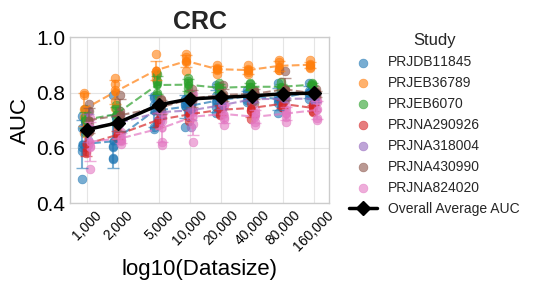

In [1]:
# 导入必要的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import re # 用于解析 datasize

# --- 1. 加载数据 ---
file_path = 'Data/pretraining_datasize/result/summary_ROC_results_datasize_CRC.csv'
try:
    df_full = pd.read_csv(file_path) # 先加载完整数据
    print("数据加载成功。")
except FileNotFoundError:
    print(f"错误：找不到文件 {file_path}")
    exit()

# --- 1.5 选择并过滤疾病 ---
if df_full.empty:
    print("错误：CSV 文件为空。")
    exit()

if 'disease' not in df_full.columns:
    print("错误：CSV 文件中缺少 'disease' 列。")
    exit()

diseases_in_file = df_full['disease'].unique()
if len(diseases_in_file) == 0:
    print("错误：未在 'disease' 列中找到任何疾病名称。")
    exit()

target_disease = 'CRC'
print(f"将绘制疾病 '{target_disease}' 的数据。")
df = df_full[df_full['disease'] == target_disease].copy()

if df.empty:
    print(f"错误：在文件中找到了疾病 '{target_disease}'，但筛选后没有数据。")
    exit()

# --- 2. 数据清洗与转换 ---
def parse_datasize(size_str):
    size_str = str(size_str).lower().strip()
    multiplier = 1
    if 'k' in size_str:
        multiplier = 1000
        size_str = size_str.replace('k', '')
    elif 'w' in size_str:
        multiplier = 10000
        size_str = size_str.replace('w', '')
    try:
        num_part = re.findall(r"[-+]?\d*\.?\d+", size_str)
        if num_part:
            return float(num_part[0]) * multiplier
        else:
            return np.nan
    except ValueError:
        return np.nan

df['datasize_numeric'] = df['datasize'].apply(parse_datasize)
df['auc'] = pd.to_numeric(df['auc'], errors='coerce')
df.dropna(subset=['datasize_numeric', 'auc'], inplace=True)

# --- 新增：移除 datasize_numeric 为 120000 (即 '12w') 的数据 ---
datasize_to_remove = 120000
df = df[df['datasize_numeric'] != datasize_to_remove].copy()
# -------------------------------------------------------------

if df.empty:
    print(f"错误：疾病 '{target_disease}' 的数据在处理和移除 '12w' 数据后为空。") # 更新了错误信息
    exit()

df.sort_values('datasize_numeric', inplace=True)

# --- MODIFICATION HERE: Sort unique_studies ---
unique_studies = sorted(df['test_study'].unique()) # Sort the study names
# --- END MODIFICATION ---

unique_datasizes = sorted(df['datasize_numeric'].unique()) # unique_datasizes 将不再包含 120000

# --- 3. 计算统计数据 --- (基于过滤后的df)
grouped_stats = df.groupby(['datasize_numeric', 'test_study'])['auc'].agg(['mean', 'std']).reset_index()
overall_mean_auc = df.groupby('datasize_numeric')['auc'].mean().reset_index()

# --- 4. 绘图 ---
disease_name = target_disease
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(6.5, 3))

def get_tab10_colors(n): # Renamed from get_set3_colors as it uses 'tab10'
    """Generates colors from the tab10 (Tableau10) colormap, cycling if necessary."""
    cmap = plt.cm.get_cmap('tab10')
    num_colors_in_map = cmap.N
    if n <= 0: return []
    return [cmap(i % num_colors_in_map) for i in range(n)]
palette = get_tab10_colors(len(unique_studies))

color_map = dict(zip(unique_studies, palette)) # This will now use sorted unique_studies
offset_scale = 0.03

for i, study in enumerate(unique_studies): # Iteration will be based on sorted studies
    study_data_grouped = grouped_stats[grouped_stats['test_study'] == study]
    study_data_raw = df[df['test_study'] == study] # 使用过滤后的 df
    color = color_map[study]
    current_offset_factor = (i - len(unique_studies) / 2) * offset_scale
    x_data_grouped_offset = study_data_grouped['datasize_numeric'] * (1 + current_offset_factor)
    # x_data_raw_offset = study_data_raw['datasize_numeric'] * (1 + current_offset_factor) #  这行在原代码中未使用，保持注释

    plt.errorbar(x_data_grouped_offset, study_data_grouped['mean'],
                 yerr=study_data_grouped['std'].fillna(0),
                 fmt='none',
                 capsize=4,
                 ecolor=color,
                 label='_nolegend_',
                 alpha=0.6,
                 elinewidth=1.5)

    plt.plot(x_data_grouped_offset, study_data_grouped['mean'],
             linestyle='--',
             marker='o',
             markersize=5,
             color=color,
             label='_nolegend_',
             alpha=0.7)

for i, study in enumerate(unique_studies): # Iteration will be based on sorted studies
    subset = df[df['test_study'] == study] # 使用过滤后的 df
    color = color_map[study]
    current_offset_factor = (i - len(unique_studies) / 2) * offset_scale
    x_data_subset_offset = subset['datasize_numeric'] * (1 + current_offset_factor)

    plt.scatter(x_data_subset_offset, subset['auc'],
                color=color,
                label=study, # Labels in legend will now be sorted
                s=40,
                alpha=0.6,
                # edgecolors='grey',
                linewidth=0.5)

plt.plot(overall_mean_auc['datasize_numeric'], overall_mean_auc['auc'], # overall_mean_auc 也基于过滤后的 df
         linestyle='-',
         marker='D',
         color='black',
         linewidth=2.5,
         markersize=7,
         label='Overall Average AUC',
         zorder=5)

# --- 5. 设置图形属性 ---
plt.xlabel("log10(Datasize)", fontsize=16)
plt.ylabel("AUC", fontsize=16)
plt.title(f"{disease_name}", fontsize=18, fontweight='bold')
plt.xscale('log')

def format_datasize_labels(value, pos):
    num = int(round(float(value)))
    return f"{num:,}"

# unique_datasizes 现在已经不包含 120000，所以对应的 '12w' 刻度不会被创建
plt.xticks(ticks=unique_datasizes, labels=[format_datasize_labels(ds, None) for ds in unique_datasizes], rotation=45, )
ax = plt.gca()
ax.xaxis.set_minor_locator(mticker.NullLocator())

min_auc_val = df['auc'].min() if not df.empty else 0.5 # 处理df可能为空的情况
max_auc_val = df['auc'].max() if not df.empty else 0.8 # 处理df可能为空的情况, though not directly used for ylim in this version
plt.ylim(0.4, 1)

ax.xaxis.label.set_color('black')
ax.yaxis.label.set_color('black')
ax.tick_params(axis='x', colors='black', labelsize=10)
ax.tick_params(axis='y', colors='black', labelsize=15)

ax.grid(True, which="major", axis='y', ls="-", alpha=0.5)
ax.grid(True, which="major", axis='x', ls="-", alpha=0.5)
ax.grid(False, which="minor")

plt.legend(title='Study', bbox_to_anchor=(1.03, 1.1), loc="upper left", fontsize=10, title_fontsize=12)
plt.tight_layout(rect=[0, 0, 0.85, 1])

# 保存图像，可以指定分辨率(dpi)和去除多余空白(bbox_inches='tight')
image_description = "AUC_Datasize_LogScale" # 约3-4个词的描述
filename = f"{disease_name}_{image_description}.png" # 例如 CRC_AUC_Datasize_LogScale.png
plt.savefig("Figures/"+filename, dpi=300, bbox_inches='tight')
print(f"图表已保存为: {filename}")

plt.show()

数据加载成功。
将绘制疾病 'IBD' 的数据。


/tmp/ipykernel_183349/3462643709.py:91: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10')


图表已保存为: IBD_AUC_Datasize_LogScale.png


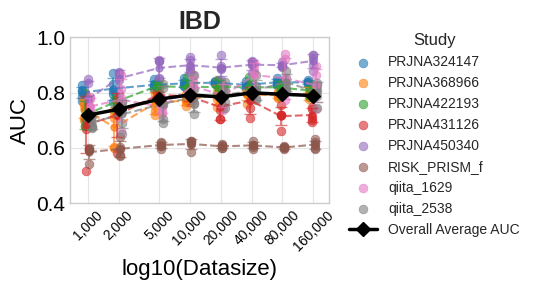

In [2]:
# 导入必要的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import re # 用于解析 datasize

# --- 1. 加载数据 ---
file_path = 'Data/pretraining_datasize/result/summary_ROC_results_datasize_IBD.csv'
try:
    df_full = pd.read_csv(file_path) # 先加载完整数据
    print("数据加载成功。")
except FileNotFoundError:
    print(f"错误：找不到文件 {file_path}")
    exit()

# --- 1.5 选择并过滤疾病 ---
if df_full.empty:
    print("错误：CSV 文件为空。")
    exit()

if 'disease' not in df_full.columns:
    print("错误：CSV 文件中缺少 'disease' 列。")
    exit()

diseases_in_file = df_full['disease'].unique()
if len(diseases_in_file) == 0:
    print("错误：未在 'disease' 列中找到任何疾病名称。")
    exit()

target_disease = 'IBD'
print(f"将绘制疾病 '{target_disease}' 的数据。")
df = df_full[df_full['disease'] == target_disease].copy()

if df.empty:
    print(f"错误：在文件中找到了疾病 '{target_disease}'，但筛选后没有数据。")
    exit()

# --- 2. 数据清洗与转换 ---
def parse_datasize(size_str):
    size_str = str(size_str).lower().strip()
    multiplier = 1
    if 'k' in size_str:
        multiplier = 1000
        size_str = size_str.replace('k', '')
    elif 'w' in size_str:
        multiplier = 10000
        size_str = size_str.replace('w', '')
    try:
        num_part = re.findall(r"[-+]?\d*\.?\d+", size_str)
        if num_part:
            return float(num_part[0]) * multiplier
        else:
            return np.nan
    except ValueError:
        return np.nan

df['datasize_numeric'] = df['datasize'].apply(parse_datasize)
df['auc'] = pd.to_numeric(df['auc'], errors='coerce')
df.dropna(subset=['datasize_numeric', 'auc'], inplace=True)

# --- 新增：移除 datasize_numeric 为 120000 (即 '12w') 的数据 ---
datasize_to_remove = 120000
df = df[df['datasize_numeric'] != datasize_to_remove].copy()
# -------------------------------------------------------------

if df.empty:
    print(f"错误：疾病 '{target_disease}' 的数据在处理和移除 '12w' 数据后为空。") # 更新了错误信息
    exit()

df.sort_values('datasize_numeric', inplace=True)

# --- MODIFICATION HERE: Sort unique_studies ---
unique_studies = sorted(df['test_study'].unique()) # Sort the study names
# --- END MODIFICATION ---

unique_datasizes = sorted(df['datasize_numeric'].unique()) # unique_datasizes 将不再包含 120000

# --- 3. 计算统计数据 --- (基于过滤后的df)
grouped_stats = df.groupby(['datasize_numeric', 'test_study'])['auc'].agg(['mean', 'std']).reset_index()
overall_mean_auc = df.groupby('datasize_numeric')['auc'].mean().reset_index()

# --- 4. 绘图 ---
disease_name = target_disease
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(6.5, 3))

def get_tab10_colors(n): # Renamed from get_set3_colors as it uses 'tab10'
    """Generates colors from the tab10 (Tableau10) colormap, cycling if necessary."""
    cmap = plt.cm.get_cmap('tab10')
    num_colors_in_map = cmap.N
    if n <= 0: return []
    return [cmap(i % num_colors_in_map) for i in range(n)]
palette = get_tab10_colors(len(unique_studies))

color_map = dict(zip(unique_studies, palette)) # This will now use sorted unique_studies
offset_scale = 0.03

for i, study in enumerate(unique_studies): # Iteration will be based on sorted studies
    study_data_grouped = grouped_stats[grouped_stats['test_study'] == study]
    study_data_raw = df[df['test_study'] == study] # 使用过滤后的 df
    color = color_map[study]
    current_offset_factor = (i - len(unique_studies) / 2) * offset_scale
    x_data_grouped_offset = study_data_grouped['datasize_numeric'] * (1 + current_offset_factor)
    # x_data_raw_offset = study_data_raw['datasize_numeric'] * (1 + current_offset_factor) #  这行在原代码中未使用，保持注释

    plt.errorbar(x_data_grouped_offset, study_data_grouped['mean'],
                 yerr=study_data_grouped['std'].fillna(0),
                 fmt='none',
                 capsize=4,
                 ecolor=color,
                 label='_nolegend_',
                 alpha=0.6,
                 elinewidth=1.5)

    plt.plot(x_data_grouped_offset, study_data_grouped['mean'],
             linestyle='--',
             marker='o',
             markersize=5,
             color=color,
             label='_nolegend_',
             alpha=0.7)

for i, study in enumerate(unique_studies): # Iteration will be based on sorted studies
    subset = df[df['test_study'] == study] # 使用过滤后的 df
    color = color_map[study]
    current_offset_factor = (i - len(unique_studies) / 2) * offset_scale
    x_data_subset_offset = subset['datasize_numeric'] * (1 + current_offset_factor)

    plt.scatter(x_data_subset_offset, subset['auc'],
                color=color,
                label=study, # Labels in legend will now be sorted
                s=40,
                alpha=0.6,
                # edgecolors='grey',
                linewidth=0.5)

plt.plot(overall_mean_auc['datasize_numeric'], overall_mean_auc['auc'], # overall_mean_auc 也基于过滤后的 df
         linestyle='-',
         marker='D',
         color='black',
         linewidth=2.5,
         markersize=7,
         label='Overall Average AUC',
         zorder=5)

# --- 5. 设置图形属性 ---
plt.xlabel("log10(Datasize)", fontsize=16)
plt.ylabel("AUC", fontsize=16)
plt.title(f"{disease_name}", fontsize=18, fontweight='bold')
plt.xscale('log')

def format_datasize_labels(value, pos):
    num = int(round(float(value)))
    return f"{num:,}"

# unique_datasizes 现在已经不包含 120000，所以对应的 '12w' 刻度不会被创建
plt.xticks(ticks=unique_datasizes, labels=[format_datasize_labels(ds, None) for ds in unique_datasizes], rotation=45, )
ax = plt.gca()
ax.xaxis.set_minor_locator(mticker.NullLocator())

min_auc_val = df['auc'].min() if not df.empty else 0.5 # 处理df可能为空的情况
max_auc_val = df['auc'].max() if not df.empty else 0.8 # 处理df可能为空的情况, though not directly used for ylim in this version
plt.ylim(0.4, 1)

ax.xaxis.label.set_color('black')
ax.yaxis.label.set_color('black')
ax.tick_params(axis='x', colors='black', labelsize=10)
ax.tick_params(axis='y', colors='black', labelsize=15)

ax.grid(True, which="major", axis='y', ls="-", alpha=0.5)
ax.grid(True, which="major", axis='x', ls="-", alpha=0.5)
ax.grid(False, which="minor")

plt.legend(title='Study', bbox_to_anchor=(1.03, 1.1), loc="upper left", fontsize=10, title_fontsize=12)
plt.tight_layout(rect=[0, 0, 0.85, 1])

# 保存图像，可以指定分辨率(dpi)和去除多余空白(bbox_inches='tight')
image_description = "AUC_Datasize_LogScale" # 约3-4个词的描述
filename = f"{disease_name}_{image_description}.png" # 例如 CRC_AUC_Datasize_LogScale.png
plt.savefig("Figures/"+filename, dpi=300, bbox_inches='tight')
print(f"图表已保存为: {filename}")

plt.show()

# Shuffle embedding 消融实验

## 对embedding进行shuffle处理，对100维的进行打乱处理

In [6]:
import pandas as pd
import numpy as np

def shuffle_along_otu_dimension(input_file, output_file):
    """
    读取一个 embedding 文件。对于每一个维度（列），
    将其在所有 OTU 之间的值进行随机打乱。

    例如，所有 OTU 的第 1 个维度的值会被随机打乱并重新分配给所有 OTU。
    这个过程会对所有维度独立进行。

    Args:
        input_file (str): 输入文件的路径。
        output_file (str): 输出文件的路径。
    """
    print(f"正在从 '{input_file}' 读取数据...")
    # 1. 使用 pandas 读取数据
    #    第一列作为 OTU 名称 (index)，其余为数据
    try:
        df = pd.read_csv(input_file, sep=' ', header=None, index_col=0)
    except Exception as e:
        print(f"读取文件时出错: {e}")
        print("请确保文件是空格分隔的，且第一列是 OTU 名称。")
        return

    print("正在沿着 OTU 维度 (按列) 打乱数据...")
    df_shuffled = df.apply(lambda x: x.sample(frac=1).reset_index(drop=True))

    # 将原始的 OTU 名称重新赋给打乱后的 DataFrame
    df_shuffled.index = df.index

    print(f"正在将打乱后的数据写入 '{output_file}'...")
    df_shuffled.to_csv(output_file, sep=' ', header=False, index=True)

    print("\n操作完成！")

# --- 执行代码 ---
input_path = '/home/cjj/projects/microbial-embeddings/data/social_niche_embedding_100.txt'
# 建议使用一个能清晰描述操作的输出文件名
output_path = 'Data/shuffle_embedding/shuffled_embedding1_100.txt'

shuffle_along_otu_dimension(input_path, output_path)

正在从 '/home/cjj/projects/microbial-embeddings/data/social_niche_embedding_100.txt' 读取数据...
正在沿着 OTU 维度 (按列) 打乱数据...
正在将打乱后的数据写入 'Data/shuffle_embedding/shuffled_embedding1_100.txt'...

操作完成！


##  获取训练结果

In [7]:

import os
import torch
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from sklearn import metrics
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, matthews_corrcoef
from biom import load_table
 
# 配置路径
base_dir = "Data/shuffle_embedding/result"
 
base_data_dir = "Data/shuffle_embedding/result"
# 初始化结果容器
results = {
    'disease': [], 'test_study': [], 'auc': [], 'f1': [],
    'mcc': [], 'acc': [], 'confusion_matrix': []
}
 
def evaluate_auc_gpu(Y, prob):
    """综合性能评估函数"""
    Y = Y.numpy().astype('int')
    prob = prob.cpu().detach().numpy()
    
    # 计算ROC曲线
    fpr, tpr, _ = metrics.roc_curve(Y, prob)
    roc_auc = metrics.auc(fpr, tpr)
    
    # 计算PR曲线
    precision, recall, _ = metrics.precision_recall_curve(Y, prob)
    pr_auc = metrics.auc(recall, precision)
    
    # 计算分类指标
    y_pred = (prob > 0.5).astype(int)
    cm = confusion_matrix(Y, y_pred)
    f1 = f1_score(Y, y_pred, average='macro')
    acc = accuracy_score(Y, y_pred)
    mcc = matthews_corrcoef(Y, y_pred)
    
    return roc_auc, pr_auc, f1, mcc, acc, cm, fpr, tpr
 
def process_biom_table(biom_table, metadata_path):
    """模拟数据预处理函数（需根据实际需求实现）"""
    # 这里应包含特征工程、标准化等处理逻辑
    return {
        'features': np.random.rand(10, 100),  # 示例数据
        'labels': np.random.randint(0, 2, 10)
    }
 
def load_model(model_path):
    """模拟模型加载函数"""
    return torch.load(model_path, map_location=torch.device('cpu'))
 
def save_results(disease, study, roc_auc, pr_auc, f1, mcc, acc, cm, fpr, tpr):
    """保存分析结果"""
    # 保存指标
    results['disease'].append(disease)
    results['test_study'].append(study)
    results['auc'].append(roc_auc)
    results['f1'].append(f1)
    results['mcc'].append(mcc)
    results['acc'].append(acc)
    results['confusion_matrix'].append(str(cm))  # 将矩阵转为字符串保存
    
    # 保存ROC曲线
    roc_df = pd.DataFrame({'FPR': fpr, 'TPR': tpr})
    output_dir = os.path.join(base_dir, disease, study, "results")
    os.makedirs(output_dir, exist_ok=True)
    roc_df.to_csv(os.path.join(output_dir, "roc_curve.csv"), index=False)
 
def process_disease(disease_path):
    """处理单个疾病目录"""
    disease_name = os.path.basename(disease_path)
    print(f"\n{'='*30}\n处理疾病: {disease_name}\n{'='*30}")
    
    # 获取所有研究目录
    study_dirs = [
        d for d in os.listdir(disease_path) 
        if os.path.isdir(os.path.join(disease_path, d))
    ]
    
    # 跳过单个研究的疾病
    if len(study_dirs) <= 1:
        print(f"!! 跳过 {disease_name}，仅有 {len(study_dirs)} 个研究")
        return
    
        
    if disease_name not in ['IBD','CRC']:
        print(f"!! 跳过 {disease_name}相关研究")
        return

    
    # 检查元数据文件
    metadata_path = os.path.join(disease_path, "metadata.tsv")
    if not os.path.exists(metadata_path):
        print(f"!! 严重错误：{disease_name} 缺失元数据文件")
        return
    
    # 遍历每个研究
    for study in study_dirs:
        study_path = os.path.join(disease_path, study)
        print(f"\n-- 处理研究: {study}")
        
        # 验证必需文件
        required_files = {
            'train': 'train_loo.biom',
            'test': 'test_loo.biom',
            'model': os.path.join('results', 'attention_loo.pt')
        }
        
        
        biom_dir = os.path.join(base_data_dir,disease_name,study)
        

        # 加载数据
        train_data = load_data_imdb(f'{biom_dir}/train_loo.biom',
                                    metadata_path,
                                    group,
                                    'sample',
                                    num_steps)
        test_data = load_data_imdb(f'{biom_dir}/test_loo.biom',
                                        metadata_path,
                                        group,
                                        'sample',
                                        num_steps)
        
        train_iter = DataLoader(train_data,
                                batch_size=batch_size,
                                shuffle=False)
        
        test_iter = DataLoader(test_data,
                                batch_size=batch_size,
                                shuffle=False)
        
        table = biom.load_table(f'{biom_dir}/test_loo.biom')
        study_ordered_sample_ids = table.ids(axis='sample')
        
        # 加载模型
        fid_dict = train_data()
        net = TransformerEncoder(otu_size=len(fid_dict),
                                    seq_len=num_steps+1,
                                    d_model=d_model,
                                    n_layers=n_layers,
                                    n_heads=n_heads,
                                    p_drop=p_drop,
                                    pad_id=fid_dict['<pad>'])
        
        net.load_state_dict( 
                torch.load(
                    f'{study_path}/results/attention_loo.pt',
                    map_location=torch.device('cpu')))
        
        print(net.embedding)  # 确认num_embeddings参数
        
        with torch.no_grad():
            net.eval()
            for i, (features, abundance, group_lables, mask) in enumerate(test_iter):
                pred, _ = net(features, abundance, mask)
                # print(pred)
                # 评估性能
                roc_auc, pr_auc, f1, mcc, acc, cm, fpr, tpr = evaluate_auc_gpu(group_lables, pred)
                
                pred_probabilities = torch.sigmoid(pred) 
                # print(pred_probabilities)
                if pred_probabilities.ndim > 1 and pred_probabilities.shape[1] == 1:
                    pred_probabilities = pred_probabilities.squeeze(1)
                final_true_labels = group_lables.cpu().numpy().flatten()
                final_pred_probs = pred_probabilities.cpu().numpy().flatten()
                # ---- 保存样本ID、真实标签和预测概率 ----
                output_df_data = {'TrueLabel': final_true_labels, 'PredictedProbability': final_pred_probs}
                can_save_with_ids = False
                if study_ordered_sample_ids is not None:
                    if len(final_true_labels) == len(study_ordered_sample_ids):
                        output_df_data['SampleID'] = study_ordered_sample_ids
                        can_save_with_ids = True
                        print(f"  √ 研究 {study}: 样本ID将包含在概率输出中。")
                    else:
                        print(f"!! 错误: 研究 {study} 的预测/标签数量 ({len(final_true_labels)}) 与获取的样本ID数量 ({len(study_ordered_sample_ids)}) 不匹配!")
                        print("     概率文件将不包含SampleID列。请检查 test_dataset 的ID获取方式。")
                else:
                    print(f"!! 信息: 研究 {study} 未能获取有序样本ID，概率文件将不包含SampleID列。")
                
                predictions_df = pd.DataFrame(output_df_data)
                if can_save_with_ids and 'SampleID' in predictions_df.columns:
                    predictions_df = predictions_df[['SampleID', 'TrueLabel', 'PredictedProbability']]

                output_dir_probs = os.path.join(base_dir, disease_name, study, "results")
                os.makedirs(output_dir_probs, exist_ok=True) 
                probs_output_path = os.path.join(output_dir_probs, "attention_scores.csv")
                predictions_df.to_csv(probs_output_path, index=False)
                print(f"√ 成功保存 {study} 的样本预测概率到 {probs_output_path}")
                
                # 保存结果
                save_results(disease_name, study, roc_auc, pr_auc, f1, mcc, acc, cm, fpr, tpr)
                print(f"√ 成功保存 {study} 结果")
        

for disease_folder in os.listdir(base_dir):
    disease_path = os.path.join(base_dir, disease_folder)
    if os.path.isdir(disease_path):
        process_disease(disease_path)

model_res = pd.DataFrame({"disease":results['disease'],"study":results['test_study'],"f1":results['f1'], "auc":results['auc'], "cms":results['confusion_matrix']})
model_res.to_csv("Data/shuffle_embedding/result/attention_model_loo_suffle_embedding.csv", index=None)
# print(model_res)
model_res



处理疾病: IBD

-- 处理研究: qiita_2538


Embedding(5864, 100, padding_idx=1)


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


  √ 研究 qiita_2538: 样本ID将包含在概率输出中。
√ 成功保存 qiita_2538 的样本预测概率到 Data/shuffle_embedding/result/IBD/qiita_2538/results/attention_scores.csv
√ 成功保存 qiita_2538 结果

-- 处理研究: PRJNA324147
Embedding(5864, 100, padding_idx=1)


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


  √ 研究 PRJNA324147: 样本ID将包含在概率输出中。
√ 成功保存 PRJNA324147 的样本预测概率到 Data/shuffle_embedding/result/IBD/PRJNA324147/results/attention_scores.csv
√ 成功保存 PRJNA324147 结果

-- 处理研究: qiita_1629
Embedding(5864, 100, padding_idx=1)
  √ 研究 qiita_1629: 样本ID将包含在概率输出中。
√ 成功保存 qiita_1629 的样本预测概率到 Data/shuffle_embedding/result/IBD/qiita_1629/results/attention_scores.csv
√ 成功保存 qiita_1629 结果

-- 处理研究: PRJNA450340
Embedding(5864, 100, padding_idx=1)


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


  √ 研究 PRJNA450340: 样本ID将包含在概率输出中。
√ 成功保存 PRJNA450340 的样本预测概率到 Data/shuffle_embedding/result/IBD/PRJNA450340/results/attention_scores.csv
√ 成功保存 PRJNA450340 结果

-- 处理研究: RISK_PRISM_f
Embedding(5864, 100, padding_idx=1)
  √ 研究 RISK_PRISM_f: 样本ID将包含在概率输出中。
√ 成功保存 RISK_PRISM_f 的样本预测概率到 Data/shuffle_embedding/result/IBD/RISK_PRISM_f/results/attention_scores.csv
√ 成功保存 RISK_PRISM_f 结果

-- 处理研究: PRJNA368966
Embedding(5864, 100, padding_idx=1)
  √ 研究 PRJNA368966: 样本ID将包含在概率输出中。
√ 成功保存 PRJNA368966 的样本预测概率到 Data/shuffle_embedding/result/IBD/PRJNA368966/results/attention_scores.csv
√ 成功保存 PRJNA368966 结果

-- 处理研究: PRJNA422193
Embedding(5864, 100, padding_idx=1)
  √ 研究 PRJNA422193: 样本ID将包含在概率输出中。
√ 成功保存 PRJNA422193 的样本预测概率到 Data/shuffle_embedding/result/IBD/PRJNA422193/results/attention_scores.csv
√ 成功保存 PRJNA422193 结果

-- 处理研究: PRJNA431126
Embedding(5864, 100, padding_idx=1)
  √ 研究 PRJNA431126: 样本ID将包含在概率输出中。
√ 成功保存 PRJNA431126 的样本预测概率到 Data/shuffle_embedding/result/IBD/PRJNA431126/results/attent

,disease,study,f1,auc,cms
0,IBD,qiita_2538,0.329868,0.723138,[[ 0 360]\n [ 0 349]]
1,IBD,PRJNA324147,0.284553,0.745553,[[ 0 53]\n [ 0 35]]
2,IBD,qiita_1629,0.177147,0.640315,[[ 55 0]\n [454 43]]
3,IBD,PRJNA450340,0.389423,0.769458,[[ 0 46]\n [ 0 81]]
4,IBD,RISK_PRISM_f,0.481693,0.542746,[[ 7 28]\n [101 415]]
5,IBD,PRJNA368966,0.495567,0.555230,[[13 18]\n [14 19]]
6,IBD,PRJNA422193,0.395742,0.457466,[[ 1 153]\n [ 0 269]]
7,IBD,PRJNA431126,0.521496,0.542762,[[ 7 27]\n [ 42 240]]
8,CRC,PRJNA318004,0.656454,0.687912,[[100 30]\n [ 45 53]]
9,CRC,PRJDB11845,0.626891,0.712308,[[24 26]\n [11 41]]


## 绘图

将要处理的疾病列表: IBD, CRC
正在为 'IBD' 绘制图表...


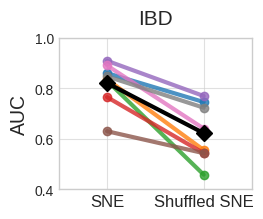

 -> 已保存图表至: auc_change_plots/IBD_auc_change.png
正在为 'CRC' 绘制图表...


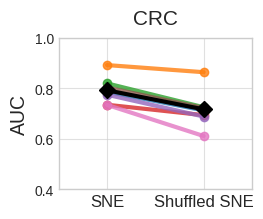

 -> 已保存图表至: auc_change_plots/CRC_auc_change.png

所有图表绘制完成！


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# --- 1. 配置与数据加载 ---

# 数据文件路径
original_embedding_path = 'Data/shuffle_embedding/result/attention_model_loo_IBD_CRC.csv'
shuffled_embedding_path = 'Data/shuffle_embedding/result/attention_model_loo_suffle_embedding.csv'

# 输出图表保存的文件夹
output_dir = "Figures"
os.makedirs(output_dir, exist_ok=True) # 如果文件夹不存在，则自动创建
# 读取并合并数据
try:
    # 为了合并，我们重命名auc列以便区分
    df_orig = pd.read_csv(original_embedding_path)
    df_shuffled = pd.read_csv(shuffled_embedding_path)

    # 基于disease和study列进行合并
    df_orig.rename(columns={'auc': 'auc_original'}, inplace=True)
    df_shuffled.rename(columns={'auc': 'auc_shuffled'}, inplace=True)
    
    df = pd.merge(df_orig[['disease', 'study', 'auc_original']],
                  df_shuffled[['disease', 'study', 'auc_shuffled']], 
                  on=['disease', 'study'])
except FileNotFoundError as e:
    print(f"错误：找不到数据文件。请检查路径是否正确。\n{e}")
    exit()

# --- 2. 绘图参数 (采纳您提供的样式) ---

# 统一可视化参数
model_positions = [0, 1]
x_labels = ['SNE', 'Shuffled SNE'] # X轴标签
cmap = plt.get_cmap('tab10')      # 使用10色循环的颜色映射
marker_style = 'o'
marker_size = 6

# 图例参数配置
legend_params = {
    'bbox_to_anchor': (1.03, 0.5),  # 图例位置在图表右侧
    'loc': 'center left',
    'ncol': 1,
    'fontsize': 10,
    'title_fontsize': 12,
    'frameon': False
}

# --- 3. 遍历每个疾病并独立绘图 ---

diseases = df['disease'].unique()
print(f"将要处理的疾病列表: {', '.join(diseases)}")

for disease in diseases:
    print(f"正在为 '{disease}' 绘制图表...")
    
    # a. 创建一个独立的画布
    fig, ax = plt.subplots(figsize=(3.2, 2.3)) # 调整尺寸以适应外部图例
    
    # b. 筛选当前疾病的数据
    disease_df = df[df['disease'] == disease].copy()

    # --- NEW: 按研究名称排序以保持颜色一致 ---
    disease_df.sort_values(by='study', inplace=True)
    disease_df.reset_index(drop=True, inplace=True) # 重置索引以正确映射颜色
    
    # c. 计算平均AUC
    mean_orig = disease_df['auc_original'].mean()
    mean_shuffled = disease_df['auc_shuffled'].mean()

    # d. 准备图例元素
    legend_handles = []
    legend_labels = []

    # e. 绘制各study的连线
    for study_idx, (_, row_data) in enumerate(disease_df.iterrows()):
        color = cmap(study_idx % 10)  # 循环使用颜色
        
        line = ax.plot(
            model_positions, # 使用数字位置进行绘图
            [row_data['auc_original'], row_data['auc_shuffled']],
            color=color,
            alpha=0.8,
            marker=marker_style,
            markersize=marker_size,
            linewidth=3,
        )[0]

        # 添加图例项
        legend_handles.append(line)
        legend_labels.append(row_data['study'])

    # f. 最后绘制平均线 (zorder确保其在最顶层)
    mean_line = ax.plot(
        model_positions, # 使用数字位置进行绘图
        [mean_orig, mean_shuffled],
        color='black',
        linestyle='-',
        linewidth=3,
        marker='D',
        markersize=8,
        zorder=100  # 确保在最上层
    )[0]
    # 将Mean图例项插入到最前面
    legend_handles.append( mean_line)
    legend_labels.append("Overall")

    # g. 子图装饰 (采纳您提供的样式)
    ax.grid(True, linestyle='-', alpha=0.6)
    ax.set_ylim(0.4, 1.0)
    if disease=='IBD_feces': disease='IBD'
    ax.set_title(disease, fontsize=15, pad=10)
    ax.set_xticks(model_positions)
    ax.set_xticklabels(x_labels, fontsize=12, )
    ax.set_ylabel('AUC', fontsize=14, )

    # --- NEW: 调整X轴的边距让标签更居中 ---
    ax.set_xlim(-0.5, 1.5)

    # h. 添加统一图例
    # ax.legend(
    #     handles=legend_handles,
    #     labels=legend_labels,
    #     **legend_params
    # )
    
    # 调整布局以防止标签被截断
    fig.tight_layout(rect=[0, 0, 0.85, 1]) # 调整右边界给图例留出空间
    display(fig)
    # i. 保存高清图像
    output_filename = os.path.join(output_dir, f"{disease}_auc_change.png")
    plt.savefig(output_filename, dpi=300, bbox_inches='tight')
    plt.close(fig) # 关闭画布，释放内存
    
    print(f" -> 已保存图表至: {output_filename}")

print("\n所有图表绘制完成！")

# 模型的Attention部分分析（IBD，CRC数据集）

## 获取模型的pooling层的输出

In [ ]:
import biom
import torch
from torch.utils.data import DataLoader
import numpy as np

# --- 主循环 ---
ratio_weight = []
all_combined_sorted_tables = {} # 用于存储每个fold的结果（可选）

for n in range(1, 9): # 循环从 1 到 6
    print(f"--- Processing Fold {n} ---")
    train_biom_path = f"Data/IBD_CRC_model/IBD/train_{n}.biom"
    test_biom_path = f"Data/IBD_CRC_model/IBD/test_{n}.biom"
    combined_sorted_biom_path = f"Data/IBD_CRC_model/IBD/combined_sorted_loo_{n}.biom" # 输出文件名

    # === 开始合并和排序 BIOM 文件 ===
    try:

        train_table = biom.load_table(train_biom_path)
        test_table = biom.load_table(test_biom_path)

        combined_table = train_table.merge(test_table)
        # 3. 获取合并后的所有样本 ID
        combined_sample_ids = combined_table.ids(axis='sample')

        sorted_combined_table = combined_table

        # 存储结果 (可选)
        all_combined_sorted_tables[n] = sorted_combined_table

        # 6. (可选) 保存合并且排序后的 BIOM 文件为 HDF5 格式
        print(f"Saving combined and sorted table to: {combined_sorted_biom_path}")
        # 使用 HDF5 格式写入，推荐的方式
        with biom.util.biom_open(combined_sorted_biom_path, 'w') as f:
            # 'generated by script' 是创建者信息，可以修改
            sorted_combined_table.to_hdf5(f, "combined_sorted_script")
        print("BIOM file saved successfully.")

    except Exception as e:
        print(f"Error processing BIOM files for fold {n}: {e}")
        print("Skipping DataLoader setup and model evaluation for this fold.")
        continue # 如果BIOM处理出错，跳过该fold的后续步骤


In [11]:
import os
import numpy as np
import pandas as pd
metadata = "Data/IBD_CRC_model/IBD/IBD_data/metadata.tsv"
output_dir = "Data/IBD_CRC_model/IBD/result"
ratio_weight = []
for n in range(1,9):
    dataset_biom = f"Data/IBD_CRC_model/IBD/IBD_data/combined_sorted_loo_{n}.biom"
    
    all_data = load_data_imdb(dataset_biom,
                                metadata,
                                group,
                                'sample',
                                num_steps)

    all_iter = DataLoader(all_data,
                           batch_size=batch_size,
                           shuffle=False)

    
    fid_dict = all_data()
    # test_fid_dict = test_data()
    net = TransformerEncoder(
                            otu_size=len(fid_dict),
                             seq_len=num_steps+1,
                             d_model=d_model,
                             n_layers=n_layers,
                             n_heads=n_heads,
                             p_drop=p_drop,
                             pad_id=fid_dict['<pad>'])

    # print(fid_dict.idx_to_token)
    print(f"pad:{fid_dict['<pad>']}")
    print(f"cls:{fid_dict['cls']}")
    
    net.load_state_dict( 
            torch.load(
                f'Data/IBD_CRC_model/IBD/attention_weight/attention_{n}.pt',
                map_location=torch.device('cpu')))
    
    group_lables = []
    features_list= []
    embeddings = []
    
    with torch.no_grad():
        net.eval()
        for i, (features, abundance, group_lables, mask) in enumerate(all_iter):
            group_lables = group_lables.tolist()

            _, embedding = net(features, abundance, mask, encoder=True)

            features_list = features
             # batch * num_heads * seq_len+1 * seq_len+1
    embeddings = np.array(embedding)
    print(embeddings.shape)
    print(embeddings.max())
    print(embeddings.min())
    print(embeddings.mean())
    embeddings_output_path = os.path.join(output_dir, f"embedings_pool_{n}.npy")
    labels_output_path = os.path.join(output_dir, f"group_labels_pool_{n}.npy")
    # Save the arrays
    print(f"Saving weights for fold {n} to: {embeddings_output_path}")
    np.save(embeddings_output_path, embeddings)
    print(f"Saving labels for fold {n} to: {labels_output_path}")
    np.save(labels_output_path, group_lables)
    

pad:1
cls:0
(2514, 100)
1.1962814
-0.5139156
0.06598577
Saving weights for fold 1 to: Data/IBD_CRC_model/IBD/result/embedings_pool_1.npy
Saving labels for fold 1 to: Data/IBD_CRC_model/IBD/result/group_labels_pool_1.npy
pad:1
cls:0
(2514, 100)
1.2468922
-0.61295784
0.06226689
Saving weights for fold 2 to: Data/IBD_CRC_model/IBD/result/embedings_pool_2.npy
Saving labels for fold 2 to: Data/IBD_CRC_model/IBD/result/group_labels_pool_2.npy
pad:1
cls:0
(2514, 100)
1.2901565
-0.90263367
0.092163175
Saving weights for fold 3 to: Data/IBD_CRC_model/IBD/result/embedings_pool_3.npy
Saving labels for fold 3 to: Data/IBD_CRC_model/IBD/result/group_labels_pool_3.npy
pad:1
cls:0
(2514, 100)
1.6364316
-1.5763137
0.05642589
Saving weights for fold 4 to: Data/IBD_CRC_model/IBD/result/embedings_pool_4.npy
Saving labels for fold 4 to: Data/IBD_CRC_model/IBD/result/group_labels_pool_4.npy
pad:1
cls:0
(2514, 100)
0.9320917
-0.40767506
0.008184334
Saving weights for fold 5 to: Data/IBD_CRC_model/IBD/result

In [13]:
import biom
import torch
from torch.utils.data import DataLoader
import numpy as np

# --- 主循环 ---
ratio_weight = []
all_combined_sorted_tables = {} # 用于存储每个fold的结果（可选）

for n in range(1, 8): # 循环从 1 到 6
    print(f"--- Processing Fold {n} ---")
    train_biom_path = f"Data/IBD_CRC_model/CRC/CRC_data/train_{n}.biom"
    test_biom_path = f"Data/IBD_CRC_model/CRC/CRC_data/test_{n}.biom"
    combined_sorted_biom_path = f"Data/IBD_CRC_model/CRC/CRC_data/combined_sorted_loo_{n}.biom" # 输出文件名

    # === 开始合并和排序 BIOM 文件 ===
    try:

        train_table = biom.load_table(train_biom_path)
        test_table = biom.load_table(test_biom_path)

        combined_table = train_table.merge(test_table)
        # 3. 获取合并后的所有样本 ID
        combined_sample_ids = combined_table.ids(axis='sample')

        sorted_combined_table = combined_table

        # 存储结果 (可选)
        all_combined_sorted_tables[n] = sorted_combined_table

        # 6. (可选) 保存合并且排序后的 BIOM 文件为 HDF5 格式
        print(f"Saving combined and sorted table to: {combined_sorted_biom_path}")
        # 使用 HDF5 格式写入，推荐的方式
        with biom.util.biom_open(combined_sorted_biom_path, 'w') as f:
            # 'generated by script' 是创建者信息，可以修改
            sorted_combined_table.to_hdf5(f, "combined_sorted_script")
        print("BIOM file saved successfully.")

    except Exception as e:
        print(f"Error processing BIOM files for fold {n}: {e}")
        print("Skipping DataLoader setup and model evaluation for this fold.")
        continue # 如果BIOM处理出错，跳过该fold的后续步骤


--- Processing Fold 1 ---
Saving combined and sorted table to: Data/IBD_CRC_model/CRC/CRC_data/combined_sorted_loo_1.biom
BIOM file saved successfully.
--- Processing Fold 2 ---
Saving combined and sorted table to: Data/IBD_CRC_model/CRC/CRC_data/combined_sorted_loo_2.biom
BIOM file saved successfully.
--- Processing Fold 3 ---
Saving combined and sorted table to: Data/IBD_CRC_model/CRC/CRC_data/combined_sorted_loo_3.biom
BIOM file saved successfully.
--- Processing Fold 4 ---
Saving combined and sorted table to: Data/IBD_CRC_model/CRC/CRC_data/combined_sorted_loo_4.biom
BIOM file saved successfully.
--- Processing Fold 5 ---
Saving combined and sorted table to: Data/IBD_CRC_model/CRC/CRC_data/combined_sorted_loo_5.biom
BIOM file saved successfully.
--- Processing Fold 6 ---
Saving combined and sorted table to: Data/IBD_CRC_model/CRC/CRC_data/combined_sorted_loo_6.biom
BIOM file saved successfully.
--- Processing Fold 7 ---
Saving combined and sorted table to: Data/IBD_CRC_model/CRC/CR

In [15]:
import os
import numpy as np
import pandas as pd
metadata = "Data/IBD_CRC_model/CRC/CRC_data/metadata.tsv"
output_dir = "Data/IBD_CRC_model/CRC/result"
ratio_weight = []
for n in range(1,8):
    dataset_biom = f"Data/IBD_CRC_model/CRC/CRC_data/combined_sorted_loo_{n}.biom"
    
    all_data = load_data_imdb(dataset_biom,
                                metadata,
                                group,
                                'sample',
                                num_steps)

    all_iter = DataLoader(all_data,
                           batch_size=batch_size,
                           shuffle=False)

    
    fid_dict = all_data()
    # test_fid_dict = test_data()
    net = TransformerEncoder(
                            otu_size=len(fid_dict),
                             seq_len=num_steps+1,
                             d_model=d_model,
                             n_layers=n_layers,
                             n_heads=n_heads,
                             p_drop=p_drop,
                             pad_id=fid_dict['<pad>'])

    # print(fid_dict.idx_to_token)
    print(f"pad:{fid_dict['<pad>']}")
    print(f"cls:{fid_dict['cls']}")
    
    net.load_state_dict( 
            torch.load(
                f'Data/IBD_CRC_model/CRC/attention_weight/attention_{n}.pt',
                map_location=torch.device('cpu')))
    
    group_lables = []
    features_list= []
    embeddings = []
    
    with torch.no_grad():
        net.eval()
        for i, (features, abundance, group_lables, mask) in enumerate(all_iter):
            group_lables = group_lables.tolist()

            _, embedding = net(features, abundance, mask, encoder=True)

            features_list = features
             # batch * num_heads * seq_len+1 * seq_len+1
    embeddings = np.array(embedding)
    print(embeddings.shape)
    print(embeddings.max())
    print(embeddings.min())
    print(embeddings.mean())
    embeddings_output_path = os.path.join(output_dir, f"embedings_pool_{n}.npy")
    labels_output_path = os.path.join(output_dir, f"group_labels_pool_{n}.npy")
    # Save the arrays
    print(f"Saving weights for fold {n} to: {embeddings_output_path}")
    np.save(embeddings_output_path, embeddings)
    print(f"Saving labels for fold {n} to: {labels_output_path}")
    np.save(labels_output_path, group_lables)

    

pad:1
cls:0
(1034, 100)
1.0798669
-0.7909851
0.08196455
Saving weights for fold 1 to: Data/IBD_CRC_model/CRC/result/embedings_pool_1.npy
Saving labels for fold 1 to: Data/IBD_CRC_model/CRC/result/group_labels_pool_1.npy
pad:1
cls:0
(1034, 100)
1.0813861
-0.6654271
0.058802977
Saving weights for fold 2 to: Data/IBD_CRC_model/CRC/result/embedings_pool_2.npy
Saving labels for fold 2 to: Data/IBD_CRC_model/CRC/result/group_labels_pool_2.npy
pad:1
cls:0
(1034, 100)
1.356915
-0.8361503
0.07058256
Saving weights for fold 3 to: Data/IBD_CRC_model/CRC/result/embedings_pool_3.npy
Saving labels for fold 3 to: Data/IBD_CRC_model/CRC/result/group_labels_pool_3.npy
pad:1
cls:0
(1034, 100)
1.1245787
-0.6876252
0.0838683
Saving weights for fold 4 to: Data/IBD_CRC_model/CRC/result/embedings_pool_4.npy
Saving labels for fold 4 to: Data/IBD_CRC_model/CRC/result/group_labels_pool_4.npy
pad:1
cls:0
(1034, 100)
1.0477724
-0.84979796
0.06998199
Saving weights for fold 5 to: Data/IBD_CRC_model/CRC/result/embe

##  绘制attention_pooling的结果图

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap, Normalize
from matplotlib.patches import Patch
from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.spatial.distance import pdist
import os

def cluster_and_reorder(data_matrix, labels_array=None, cluster_rows=True, cluster_cols=True,
                        row_method='average', row_metric='euclidean',
                        col_method='average', col_metric='euclidean'):
    """
    Applies hierarchical clustering to reorder rows and/or columns of a data matrix.
    """
    reordered_matrix = data_matrix.copy()
    reordered_labels = labels_array.copy() if labels_array is not None else None
    if cluster_rows and data_matrix.shape[0] > 1:
        try:
            row_link = linkage(pdist(reordered_matrix, metric=row_metric), method=row_method)
            row_order_indices = leaves_list(row_link)
            reordered_matrix = reordered_matrix[row_order_indices, :]
            if reordered_labels is not None:
                reordered_labels = reordered_labels[row_order_indices, :]
        except ValueError:
            print("Warning: Could not cluster rows.")
    if cluster_cols and reordered_matrix.shape[1] > 1:
        try:
            col_link = linkage(pdist(reordered_matrix.T, metric=col_metric), method=col_method)
            col_order_indices = leaves_list(col_link)
            reordered_matrix = reordered_matrix[:, col_order_indices]
        except ValueError:
             print("Warning: Could not cluster columns.")
    return reordered_matrix, reordered_labels


def plot_clustered_heatmap(
    dataset_name: str,
    data_path: str,
    num_batches: int,
    group_info: dict,
    file_templates: dict,
    colormap: str = 'RdBu_r',
    figsize: tuple = (6, 4),
    output_filename: str = None
    ):
    """
    Loads, averages, clusters, and plots attention pooling data with professional alignment.
    """
    # ... (Code for loading and clustering data is unchanged) ...
    # --- 1. Load and Average Data ---
    all_embeddings = []
    for i in range(1, num_batches + 1):
        embedding_file = os.path.join(data_path, file_templates['weights'].format(i))
        if os.path.exists(embedding_file):
            all_embeddings.append(np.load(embedding_file))
        else:
            print(f"Warning: File not found {embedding_file}")
            return
    if not all_embeddings:
        print("Error: No embedding files were loaded.")
        return
    averaged_embeddings = np.mean(np.stack(all_embeddings, axis=0), axis=0)

    # --- 2. Load Labels ---
    label_file = os.path.join(data_path, file_templates['labels'].format(1))
    labels_orig = np.load(label_file).reshape(-1, 1)

    # --- 3. Cluster Data ---
    embeddings_to_plot, labels_to_plot = cluster_and_reorder(
        averaged_embeddings, labels_array=labels_orig
    )
    
    # --- 4. Setup Plotting Environment ---
    plt.style.use('default')
    fig = plt.figure(figsize=figsize, dpi=150)
    
    abs_max = np.nanmax(np.abs(embeddings_to_plot))
    heatmap_norm = Normalize(vmin=-abs_max, vmax=abs_max)
    label_colors = list(group_info.values())
    label_cmap = ListedColormap(label_colors)

    # --- 5. Create Main Grid and Plot Heatmap ---
    main_gs = gridspec.GridSpec(1, 2, width_ratios=[1, 0.3], wspace=0.10)
    heatmap_gs = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=main_gs[0], width_ratios=[0.07, 1], wspace=0.05)
    ax_label = fig.add_subplot(heatmap_gs[0])
    ax_heatmap = fig.add_subplot(heatmap_gs[1])
    
    ax_label.imshow(labels_to_plot, aspect='auto', cmap=label_cmap, vmin=0, vmax=len(label_colors)-1)
    ax_label.set_ylabel('Samples', fontsize=18)
    ax_label.set_xticks([]); ax_label.set_yticks([])

    im = ax_heatmap.imshow(embeddings_to_plot, aspect='auto', cmap=colormap, norm=heatmap_norm)
    ax_heatmap.set_xlabel('Attention Pooling', fontsize=18)
    ax_heatmap.set_xticks([]); ax_heatmap.set_yticks([])

    # --- 6. Center the Main Title over the Heatmap Area ---
    fig.canvas.draw()
    heatmap_pos = ax_heatmap.get_position()
    label_pos = ax_label.get_position()
    heatmap_center_x = (label_pos.x0 + heatmap_pos.x1) / 2
    fig.suptitle(dataset_name, fontsize=20, x=heatmap_center_x)

    # --- 7. Create Right Panel for Legends using a Nested GridSpec ---
    right_panel_gs = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=main_gs[1], height_ratios=[1, 2], hspace=0.3)
    ax_legend = fig.add_subplot(right_panel_gs[0])
    ax_legend.axis('off')
    legend_elements = [Patch(facecolor=color, label=name, edgecolor='black') for name, color in group_info.items()]
    ax_legend.legend(handles=legend_elements, title="Group", loc="center left", frameon=False, fontsize=10, title_fontsize=12, labelspacing=0.8)

    # #############################################################
    # ### NEW METHOD FOR CONTROLLING COLORBAR THICKNESS ###
    # #############################################################
    
    # Create a sub-grid within the colorbar's designated cell
    # This gives us explicit control over its width.
    cbar_cell_gs = gridspec.GridSpecFromSubplotSpec(
        1, 3,  # 1 row, 3 columns
        subplot_spec=right_panel_gs[1],
        width_ratios=[0.2, 0.2, 0.6], # [Left Space, Colorbar, Right Space]
        wspace=0.1
    )

    # Add the colorbar axis to the NARROW MIDDLE column of our new sub-grid
    cbar_ax = fig.add_subplot(cbar_cell_gs[0, 1])
    
    # Create the colorbar (no 'aspect' needed now)
    cbar = fig.colorbar(im, cax=cbar_ax)
    # #############################################################

    cbar.ax.set_title('Value', fontsize=12, pad=10)
    cbar.ax.tick_params(labelsize=10)
    
    fig.tight_layout()
    fig.subplots_adjust(top=0.9)

    if output_filename:
        plt.savefig(output_filename, bbox_inches='tight')
        print(f"Plot saved to {output_filename}")
    else:
        plt.show()

/tmp/ipykernel_183349/1871351501.py:134: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


Plot saved to Figures/IBD_feces_heatmap.png


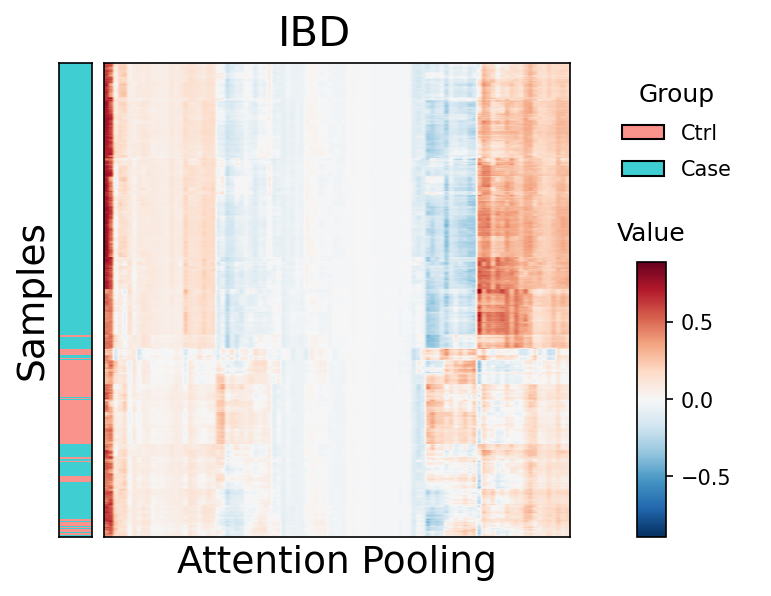

In [22]:
# --- How to Use the Refactored Function ---
plot_clustered_heatmap(
    dataset_name="IBD",
    data_path='Data/IBD_CRC_model/IBD/result',
    num_batches=8,
    group_info={'Ctrl': '#F9938B', 'Case': '#3FCFD2'},
    file_templates={
        'labels': 'group_labels_pool_{}.npy',
        'weights': 'embedings_pool_{}.npy'
    },
    colormap='RdBu_r', # Trying a new colormap
    output_filename="Figures/IBD_feces_heatmap.png"
)

/tmp/ipykernel_183349/1871351501.py:134: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


Plot saved to Figures/CRC_heatmap.png


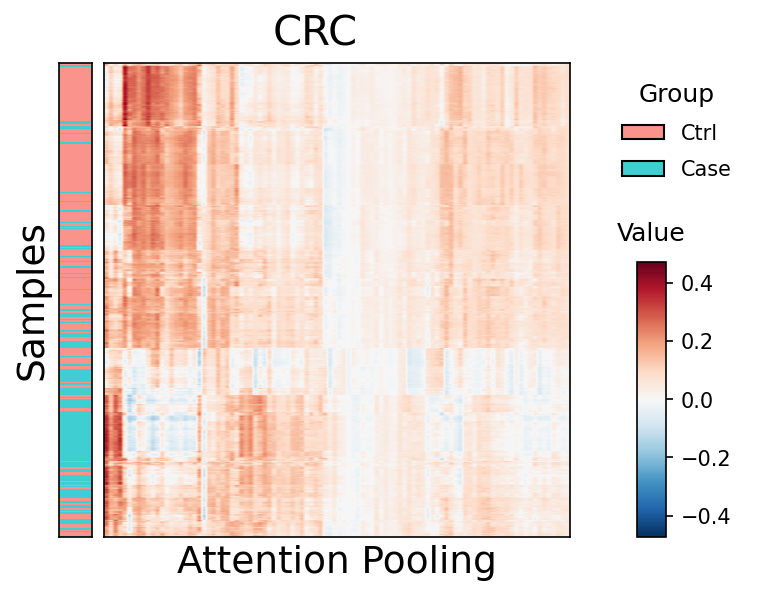

In [21]:
# --- How to Use the Refactored Function ---
plot_clustered_heatmap(
    dataset_name="CRC",
    data_path='Data/IBD_CRC_model/CRC/result',
    num_batches=7,
    group_info={'Ctrl': '#F9938B', 'Case': '#3FCFD2'},
    file_templates={
        'labels': 'group_labels_pool_{}.npy',
        'weights': 'embedings_pool_{}.npy'
    },
    colormap='RdBu_r', # Trying a new colormap
    output_filename="Figures/CRC_heatmap.png"
)

# 模型对biomarker的注意力权重分析（IBD，CRC）

## 获取模型对所有OTU的关注的注意力权重

In [23]:
metadata= 'Data/IBD_CRC_model/IBD/IBD_data/metadata.tsv'
ratio_weight = []
for n in range(1,9):
    train_biom = f"Data/IBD_CRC_model/IBD/IBD_data/train_{n}.biom"
    # test_biom = f"../IBD_data/table.biom"
    test_biom = f"Data/IBD_CRC_model/IBD/IBD_data/test_{n}.biom"
    
    train_data = load_data_imdb(train_biom,
                                metadata,
                                group,
                                'sample',
                                num_steps)
    test_data = load_data_imdb(test_biom,
                                   metadata,
                                   group,
                                   'sample',
                                   num_steps)
    print(len(train_data.fid))
    print(len(test_data.fid))
    train_iter = DataLoader(train_data,
                           batch_size=batch_size,
                           shuffle=False)
    
    test_iter = DataLoader(test_data,
                           batch_size=batch_size,
                           shuffle=False)
    
    fid_dict = train_data()
    # test_fid_dict = test_data()
    net = TransformerEncoder(
                            otu_size=len(fid_dict),
                             seq_len=num_steps+1,
                             d_model=d_model,
                             n_layers=n_layers,
                             n_heads=n_heads,
                             p_drop=p_drop,
                             pad_id=fid_dict['<pad>'])

    # print(fid_dict.idx_to_token)
    print(f"pad:{fid_dict['<pad>']}")
    print(f"cls:{fid_dict['cls']}")
    
    train_table = biom.load_table(train_biom)
    sid = train_table.ids(axis="sample")
    train_table.remove_empty()
    fid_train = train_table.ids(axis="observation")
    
    test_table = biom.load_table(test_biom)
    fid_test = test_table.ids(axis="observation")
    
    net.load_state_dict( 
            torch.load(
                f'Data/IBD_CRC_model/IBD/attention_weight/attention_{n}.pt',
                map_location=torch.device('cpu')))
    
    group_lables = []
    with torch.no_grad():
        net.eval()
        for i, (features, abundance, group_lables, mask) in enumerate(test_iter):
            group_lables = group_lables.tolist()
            pred, attention_weight = net(features, abundance, mask)
            print(attention_weight.shape) # batch * num_heads * seq_len * seq_len
    
    attention_weight_mean = torch.mean(attention_weight[:, 0,], axis=1).numpy()

    attention_map = np.zeros(test_table.shape)
    attention_map = pd.DataFrame(data=attention_map, 
                                 index = test_table.ids(axis="observation"),
                                 columns=test_table.ids(axis="sample"))
    attention_map = attention_map.T
    j = 0
    for i in attention_map.index.to_list():
        temp = features[j].numpy()
        fid_index = np.intersect1d(fid_test, [fid_dict.idx_to_token[m] for m in temp])
        feature_index = (temp != 0) & (temp != 1)
        attention_map.loc[i, fid_index] = attention_weight_mean[j, feature_index]
        j += 1
    attention_map.to_csv(f"Data/IBD_CRC_model/IBD/result/Model_{n}.csv")
    print("attention_map",attention_map.shape)


5864
5864
pad:1
cls:0
torch.Size([88, 1, 601, 601])
attention_map (88, 5861)
5864
5864
pad:1
cls:0
torch.Size([64, 1, 601, 601])
attention_map (64, 5861)
5864
5864
pad:1
cls:0
torch.Size([107, 1, 601, 601])
attention_map (107, 5861)
5864
5864
pad:1
cls:0
torch.Size([316, 1, 601, 601])
attention_map (316, 5861)
5864
5864
pad:1
cls:0
torch.Size([127, 1, 601, 601])
attention_map (127, 5861)
5864
5864
pad:1
cls:0
torch.Size([552, 1, 601, 601])
attention_map (552, 5861)
5864
5864
pad:1
cls:0
torch.Size([709, 1, 601, 601])
attention_map (709, 5861)
5864
5864
pad:1
cls:0
torch.Size([551, 1, 601, 601])
attention_map (551, 5861)


In [25]:
metadata= 'Data/IBD_CRC_model/CRC/CRC_data/metadata.tsv'
ratio_weight = []
for n in range(1,7):
    train_biom = f"Data/IBD_CRC_model/CRC/CRC_data/train_{n}.biom"
    # test_biom = f"../IBD_data/table.biom"
    test_biom = f"Data/IBD_CRC_model/CRC/CRC_data/test_{n}.biom"
    
    train_data = load_data_imdb(train_biom,
                                metadata,
                                group,
                                'sample',
                                num_steps)
    test_data = load_data_imdb(test_biom,
                                   metadata,
                                   group,
                                   'sample',
                                   num_steps)
    print(len(train_data.fid))
    print(len(test_data.fid))
    train_iter = DataLoader(train_data,
                           batch_size=batch_size,
                           shuffle=False)
    
    test_iter = DataLoader(test_data,
                           batch_size=batch_size,
                           shuffle=False)
    
    fid_dict = train_data()
    # test_fid_dict = test_data()
    net = TransformerEncoder(
                            otu_size=len(fid_dict),
                             seq_len=num_steps+1,
                             d_model=d_model,
                             n_layers=n_layers,
                             n_heads=n_heads,
                             p_drop=p_drop,
                             pad_id=fid_dict['<pad>'])

    # print(fid_dict.idx_to_token)
    print(f"pad:{fid_dict['<pad>']}")
    print(f"cls:{fid_dict['cls']}")
    
    train_table = biom.load_table(train_biom)
    sid = train_table.ids(axis="sample")
    train_table.remove_empty()
    fid_train = train_table.ids(axis="observation")
    
    test_table = biom.load_table(test_biom)
    fid_test = test_table.ids(axis="observation")
    
    net.load_state_dict( 
            torch.load(
                f'Data/IBD_CRC_model/CRC/attention_weight/attention_{n}.pt',
                map_location=torch.device('cpu')))
    
    group_lables = []
    with torch.no_grad():
        net.eval()
        for i, (features, abundance, group_lables, mask) in enumerate(test_iter):
            group_lables = group_lables.tolist()
            pred, attention_weight = net(features, abundance, mask)
            print(attention_weight.shape) # batch * num_heads * seq_len * seq_len
    
    attention_weight_mean = torch.mean(attention_weight[:, 0,], axis=1).numpy()

    attention_map = np.zeros(test_table.shape)
    attention_map = pd.DataFrame(data=attention_map, 
                                 index = test_table.ids(axis="observation"),
                                 columns=test_table.ids(axis="sample"))
    attention_map = attention_map.T
    j = 0
    for i in attention_map.index.to_list():
        temp = features[j].numpy()
        fid_index = np.intersect1d(fid_test, [fid_dict.idx_to_token[m] for m in temp])
        feature_index = (temp != 0) & (temp != 1)
        attention_map.loc[i, fid_index] = attention_weight_mean[j, feature_index]
        j += 1
    attention_map.to_csv(f"Data/IBD_CRC_model/CRC/result/Model_{n}.csv")
    print("attention_map",attention_map.shape)

2145
2145
pad:1
cls:0
torch.Size([102, 1, 601, 601])
attention_map (102, 2142)
2435
2435
pad:1
cls:0
torch.Size([153, 1, 601, 601])
attention_map (153, 2432)
2472
2472
pad:1
cls:0
torch.Size([91, 1, 601, 601])
attention_map (91, 2469)
2465
2465
pad:1
cls:0
torch.Size([255, 1, 601, 601])
attention_map (255, 2462)
2422
2422
pad:1
cls:0
torch.Size([228, 1, 601, 601])
attention_map (228, 2419)
2326
2326
pad:1
cls:0
torch.Size([146, 1, 601, 601])
attention_map (146, 2323)


## 加载linda工具分辨出来的相关biomarker

### IBD

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
ibd_biomark = pd.read_csv("Data/IBD_CRC_model/IBD/linda_res_study.csv")
filtered_df  = ibd_biomark.loc[ibd_biomark.reject == True]
unique_fids  = np.unique([str(i) for i in ibd_biomark.fid.tolist()])

# ibd_biomark = ibd_biomark.loc[[i in keep_fid for i in ibd_biomark.fid]]
grouped_df  = filtered_df.loc[:,['fid', 'log2FoldChange']].groupby("fid").mean()
ibd_biomark_enrich_control = [str(i) for i in grouped_df.loc[grouped_df.log2FoldChange < -1].index.values]
ibd_biomark_enrich_ibd = [str(i) for i in grouped_df.loc[grouped_df.log2FoldChange > 0.8].index.values]

print("Total samples:", len(ibd_biomark))
print("Total FIDs:", len(unique_fids))
print ("Number of samples:", len(filtered_df))
print("Control-enriched FIDs:", len(ibd_biomark_enrich_control))
print("IBD-enriched FIDs:", len(ibd_biomark_enrich_ibd))
print("Total FIDs:", unique_fids)

ibd_biomark_total = ibd_biomark_enrich_ibd + ibd_biomark_enrich_control
ibd_biomark_total = np.unique([str(i) for i in ibd_biomark_total])
print("IBD-enriched FIDs:", len(ibd_biomark_total))
print(ibd_biomark_total)

Total samples: 3565
Total FIDs: 1518
Number of samples: 1114
Control-enriched FIDs: 151
IBD-enriched FIDs: 92
Total FIDs: ['AB008514.1.1214' 'AB008531.1.1246' 'AB071953.1.1312' ... 'X55406.1.1331'
 'X55412.1.1333' 'X65935.1.1488']
IBD-enriched FIDs: 243
['ABIK02000013.103269.104574' 'ABIY02000114.1.1263' 'ACBX02000025.1.1217'
 'AF132270.1.1279' 'AF499899.1.1248' 'AY653232.1.1310' 'AY653235.1.1324'
 'AY850448.1.1230' 'AY850453.1.1227' 'AY850461.1.1228' 'AY850490.1.1239'
 'AY850526.1.1228' 'AY916161.1.1348' 'AY916276.1.1351' 'AY983363.1.1360'
 'AY985784.1.1352' 'AY995250.1.1365' 'CEAC01041217.2431.3934'
 'DQ014991.1.1339' 'DQ326493.1.1337' 'DQ326564.1.1352' 'DQ326785.1.1353'
 'DQ445859.1.1238' 'DQ641256.1.1334' 'DQ793375.1.1380' 'DQ794179.1.1290'
 'DQ794359.1.1305' 'DQ794369.1.1366' 'DQ796195.1.1288' 'DQ796216.1.1275'
 'DQ797791.1.1354' 'DQ797836.1.1210' 'DQ798603.1.1202' 'DQ799352.1.1291'
 'DQ799442.1.1300' 'DQ799787.1.1286' 'DQ799864.1.1291' 'DQ800028.1.1290'
 'DQ800082.1.1285' 'DQ8003

In [28]:
att_weight_bio = []
att_weight_unbio = []
value = []
group_1 = []
group_2 = []
# 初始化结果列表
results = []
for i in range(1,9):
    temp = pd.read_csv(f"Data/IBD_CRC_model/IBD/result/Model_{i}.csv", low_memory=False, index_col=0)
    valid_biomark_ibd = list(set(ibd_biomark_enrich_ibd) & set(temp.columns))
    valid_biomark_control = list(set(ibd_biomark_enrich_control) & set(temp.columns))

    # 筛选当前模型中存在的生物标志物列
    valid_biomark = list(set(ibd_biomark_total) & set(temp.columns))
    print(len(valid_biomark))   
    un_ibd_biomarker = np.setdiff1d(temp.columns.values, valid_biomark)
    att_weight_bio_ibd = np.mean(temp.loc[:,valid_biomark_ibd], axis=0).to_list()
    att_weight_bio_control = np.mean(temp.loc[:,valid_biomark_control], axis=0).to_list()
    att_weight_unbio = np.mean(temp.loc[:,un_ibd_biomarker], axis=0).to_list()

    value = value + att_weight_bio_ibd + att_weight_bio_control + att_weight_unbio

    print(len(att_weight_bio_ibd), len(att_weight_bio_control), len(att_weight_unbio),len(value))

    group_1 = group_1 + ["Biomarker_ibd"] * len(att_weight_bio_ibd) + ["Biomarker_control"] * len(att_weight_bio_control) + ["Non-biomarker"] * len(att_weight_unbio)
    group_2 = group_2 + [f"Model_{i}"] * (len(att_weight_bio_ibd) + len(att_weight_bio_control) + len(att_weight_unbio))

    # 计算当前模型的均值
    mean_bio_ibd = temp[valid_biomark_ibd].mean().mean() if len(valid_biomark_ibd) > 0 else np.nan
    mean_bio_control = temp[valid_biomark_control].mean().mean() if len(valid_biomark_control) > 0 else np.nan
    mean_unbio = temp[un_ibd_biomarker].mean().mean() if len(un_ibd_biomarker) > 0 else np.nan
    results.append({
        'Model': f'Model_{i}',
        'att_weight_bio_ibd_mean': mean_bio_ibd,
        'att_weight_bio_control_mean': mean_bio_control,
        'att_weight_unbio_mean': mean_unbio
    })
# result_df = pd.DataFrame(results)
# display(result_df)
res = pd.DataFrame({"attention_weight": value, "group1": group_1, "group2": group_2})
res.to_csv("Data/IBD_CRC_model/IBD/result/attention_weight.csv", index=None)
display(res)

243
92 151 5618 5861
243
92 151 5618 11722
243
92 151 5618 17583
243
92 151 5618 23444
243
92 151 5618 29305
243
92 151 5618 35166
243
92 151 5618 41027
243
92 151 5618 46888


,attention_weight,group1,group2
0,0.000818,Biomarker_ibd,Model_1
1,0.000471,Biomarker_ibd,Model_1
2,0.004095,Biomarker_ibd,Model_1
3,0.000413,Biomarker_ibd,Model_1
4,0.000472,Biomarker_ibd,Model_1
...,...,...,...
46883,0.000000,Non-biomarker,Model_8
46884,0.000000,Non-biomarker,Model_8
46885,0.000000,Non-biomarker,Model_8
46886,0.000194,Non-biomarker,Model_8


### CRC

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
crc_biomark = pd.read_csv("Data/IBD_CRC_model/CRC/linda_res_study.csv")
filtered_df  = crc_biomark.loc[crc_biomark.reject == True]
unique_fids  = np.unique([str(i) for i in crc_biomark.fid.tolist()])


# crc_biomark = crc_biomark.loc[[i in keep_fid for i in crc_biomark.fid]]
grouped_df  = filtered_df.loc[:,['fid', 'log2FoldChange']].groupby("fid").mean()
crc_biomark_enrich_control = [str(i) for i in grouped_df.loc[grouped_df.log2FoldChange < -0.8].index.values]
crc_biomark_enrich_crc = [str(i) for i in grouped_df.loc[grouped_df.log2FoldChange > 0.8].index.values]

print("Total samples:", len(crc_biomark))
print("Total FIDs:", len(unique_fids))
print ("Number of samples:", len(filtered_df))
print("Control-enriched FIDs:", len(crc_biomark_enrich_control))
print("CRC-enriched FIDs:", len(crc_biomark_enrich_crc))
print("Total FIDs:", unique_fids)

crc_biomark_total = crc_biomark_enrich_crc + crc_biomark_enrich_control
crc_biomark_total = np.unique([str(i) for i in crc_biomark_total])
print("CRC-enriched FIDs:", len(crc_biomark_total))
print(crc_biomark_total)

Total samples: 3115
Total FIDs: 1796
Number of samples: 342
Control-enriched FIDs: 56
CRC-enriched FIDs: 65
Total FIDs: ['AB218325.1.1438' 'AB238924.1.1486' 'AB261128.1.1492' ... 'U92197.1.1541'
 'X55410.1.1333' 'Y11466.1.1391']
CRC-enriched FIDs: 121
['AB300988.1.1342' 'AY653235.1.1324' 'AY947496.1.1209' 'AY983363.1.1360'
 'AY985779.1.1355' 'CU466602.1.1028' 'CZBP01000074.1.1200'
 'DQ014812.1.1334' 'DQ160208.1.1465' 'DQ326231.1.1338' 'DQ793359.1.1288'
 'DQ793508.1.1385' 'DQ793559.1.1253' 'DQ794280.1.1399' 'DQ794978.1.1285'
 'DQ795865.1.1286' 'DQ796116.1.1201' 'DQ796195.1.1288' 'DQ799352.1.1291'
 'DQ800299.1.1279' 'DQ800835.1.1249' 'DQ801623.1.1261' 'DQ802353.1.1286'
 'DQ803441.1.1240' 'DQ803925.1.1280' 'DQ806278.1.1302' 'DQ806540.1.1201'
 'DQ806834.1.1287' 'DQ808899.1.1291' 'DQ808930.1.1287' 'DQ809022.1.1286'
 'DQ809428.1.1286' 'DQ809549.1.1287' 'DQ823754.1.1237' 'DQ824055.1.1388'
 'DQ824417.1.1281' 'EF071257.1.1224' 'EU459837.1.1288' 'EU462209.1.1302'
 'EU462219.1.1367' 'EU462596.1.1

In [32]:
att_weight_bio = []
att_weight_unbio = []
value = []
group_1 = []
group_2 = []
# 初始化结果列表
results = []
for i in range(1,8):
    temp = pd.read_csv(f"Data/IBD_CRC_model/CRC/result/Model_{i}.csv", low_memory=False, index_col=0)

    valid_biomark_crc = list(set(crc_biomark_enrich_crc) & set(temp.columns))
    valid_biomark_control = list(set(crc_biomark_enrich_control) & set(temp.columns))

    # 筛选当前模型中存在的生物标志物列
    valid_biomark = list(set(crc_biomark_total) & set(temp.columns))
    print(len(valid_biomark))   
    un_crc_biomarker = np.setdiff1d(temp.columns.values, valid_biomark)
    att_weight_bio_crc = np.mean(temp.loc[:,valid_biomark_crc], axis=0).to_list()
    att_weight_bio_control = np.mean(temp.loc[:,valid_biomark_control], axis=0).to_list()
    att_weight_unbio = np.mean(temp.loc[:,un_crc_biomarker], axis=0).to_list()

    value = value + att_weight_bio_crc + att_weight_bio_control + att_weight_unbio

    print(len(att_weight_bio_crc), len(att_weight_bio_control), len(att_weight_unbio),len(value))

    group_1 = group_1 + ["Biomarker_crc"] * len(att_weight_bio_crc) + ["Biomarker_control"] * len(att_weight_bio_control) + ["Non-biomarker"] * len(att_weight_unbio)
    group_2 = group_2 + [f"Model_{i}"] * (len(att_weight_bio_crc) + len(att_weight_bio_control) + len(att_weight_unbio))

    # 计算当前模型的均值
    mean_bio_crc = temp[valid_biomark_crc].mean().mean() if len(valid_biomark_crc) > 0 else np.nan
    mean_bio_control = temp[valid_biomark_control].mean().mean() if len(valid_biomark_control) > 0 else np.nan
    mean_unbio = temp[un_crc_biomarker].mean().mean() if len(un_crc_biomarker) > 0 else np.nan
    results.append({
        'Model': f'Model_{i}',
        'att_weight_bio_crc_mean': mean_bio_crc,
        'att_weight_bio_control_mean': mean_bio_control,
        'att_weight_unbio_mean': mean_unbio
    })
res = pd.DataFrame({"attention_weight": value, "group1": group_1, "group2": group_2})
res.to_csv("Data/IBD_CRC_model/CRC/result/attention_weight.csv", index=None)
display(res)

118
63 55 2024 2142
118
64 54 2314 4574
121
65 56 2348 7043


121
65 56 2341 9505
117
61 56 2302 11924
115
60 55 2208 14247
121
65 56 2341 16709


,attention_weight,group1,group2
0,0.000000,Biomarker_crc,Model_1
1,0.000000,Biomarker_crc,Model_1
2,0.000000,Biomarker_crc,Model_1
3,0.000000,Biomarker_crc,Model_1
4,0.000000,Biomarker_crc,Model_1
...,...,...,...
16704,0.000000,Non-biomarker,Model_7
16705,0.000000,Non-biomarker,Model_7
16706,0.000709,Non-biomarker,Model_7
16707,0.000000,Non-biomarker,Model_7


## 绘制biomarker的平均权重

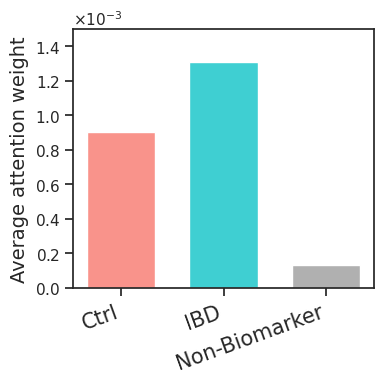

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import ScalarFormatter
import numpy as np # 用于生成示例数据

# --- 数据加载和处理部分（保持不变）---
try:
    df = pd.read_csv("Data/IBD_CRC_model/IBD/result/attention_weight.csv")
except FileNotFoundError:
    print("警告: attention_weight.csv 未找到。将使用示例数据。")
    data = {
        'group1': ['Biomarker_control']*50 + ['Biomarker_ibd']*50 + ['Non-biomarker']*50,
        'attention_weight': np.abs(np.random.randn(150) * 0.001)
    }
    df = pd.DataFrame(data)

df['attention_weight'] = df['attention_weight'].abs()
mean_values = df.groupby('group1')['attention_weight'].mean().reset_index()
rename_map = {
    'Biomarker_control': 'Ctrl',
    'Biomarker_ibd': 'IBD',
    'Non-biomarker': 'Non-Biomarker'
}
mean_values['group1'] = mean_values['group1'].replace(rename_map)
desired_order = ['Ctrl', 'IBD', 'Non-Biomarker']
mean_values = mean_values[mean_values['group1'].isin(desired_order)]
if not mean_values.empty:
    mean_values['group1'] = pd.Categorical(mean_values['group1'], categories=desired_order, ordered=True)
    mean_values = mean_values.sort_values('group1')
else:
    print("警告：重命名和筛选组后没有数据可绘制。请检查CSV中的组名和rename_map。")
# --- 数据处理结束 ---


# --- 设置图形尺寸和样式 ---
plt.figure(figsize=(4, 4.0))
sns.set_theme(style="ticks")

# 定义调色板
custom_palette = {
    'Ctrl': '#F9938B',
    'IBD': '#3FCFD2',
    'Non-Biomarker': '#B0B0B0'
}

# --- 【核心修改】使用 Matplotlib 进行精确绘图 ---
if not mean_values.empty:
    # 1. 定义每个柱子的中心位置，减小它们之间的差距
    bar_positions = [0, 0.3, 0.6]
    # 2. 定义柱子的宽度，保持不变
    bar_width = 0.2
    # 3. 准备柱子的高度和颜色
    bar_heights = mean_values['attention_weight']
    bar_colors = [custom_palette[group] for group in desired_order]

    # 4. 使用 plt.bar 进行绘图
    plt.bar(x=bar_positions,
            height=bar_heights,
            width=bar_width,
            color=bar_colors)

    # --- 其他样式设置（大部分保持不变）---
    # 设置y轴科学计数法格式
    plt.gca().yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

    # 设置标题和标签
    plt.ylabel('Average attention weight', fontsize=14)
    plt.xlabel('')

    # 5. 手动将X轴的数字位置映射回文本标签
    plt.xticks(
        ticks=bar_positions,      # 在我们定义的数字位置上设置刻度
        labels=desired_order,     # 将这些刻度显示为我们的组名
        fontsize=15,
        # fontweight='bold',
        rotation=20,
        ha='right'
    )

    # 设置y轴范围
    plt.ylim(0, 1.5e-3)

    plt.tight_layout()
    plt.savefig('Figures/ibd_attention_weights.png', dpi=300)
    plt.show()
else:
    print("由于没有指定组的数据，跳过绘图生成。")

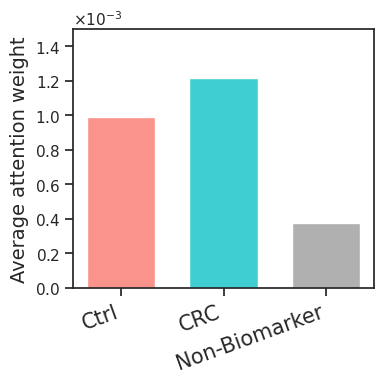

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import ScalarFormatter
import numpy as np # 用于生成示例数据

# --- 数据加载和处理部分（保持不变）---

df = pd.read_csv("Data/IBD_CRC_model/CRC/result/attention_weight.csv")


df['attention_weight'] = df['attention_weight'].abs()
mean_values = df.groupby('group1')['attention_weight'].mean().reset_index()
rename_map = {
    'Biomarker_control': 'Ctrl',
    'Biomarker_crc': 'CRC',
    'Non-biomarker': 'Non-Biomarker'
}
mean_values['group1'] = mean_values['group1'].replace(rename_map)
desired_order = ['Ctrl', 'CRC', 'Non-Biomarker']
mean_values = mean_values[mean_values['group1'].isin(desired_order)]
if not mean_values.empty:
    mean_values['group1'] = pd.Categorical(mean_values['group1'], categories=desired_order, ordered=True)
    mean_values = mean_values.sort_values('group1')
else:
    print("警告：重命名和筛选组后没有数据可绘制。请检查CSV中的组名和rename_map。")
# --- 数据处理结束 ---


# --- 设置图形尺寸和样式 ---
plt.figure(figsize=(4, 4.0))
sns.set_theme(style="ticks")

# 定义调色板
custom_palette = {
    'Ctrl': '#F9938B',
    'CRC': '#3FCFD2',
    'Non-Biomarker': '#B0B0B0'
}

# --- 【核心修改】使用 Matplotlib 进行精确绘图 ---
if not mean_values.empty:
    # 1. 定义每个柱子的中心位置，减小它们之间的差距
    bar_positions = [0, 0.3, 0.6]
    # 2. 定义柱子的宽度，保持不变
    bar_width = 0.2
    # 3. 准备柱子的高度和颜色
    bar_heights = mean_values['attention_weight']
    bar_colors = [custom_palette[group] for group in desired_order]

    # 4. 使用 plt.bar 进行绘图
    plt.bar(x=bar_positions,
            height=bar_heights,
            width=bar_width,
            color=bar_colors)

    # --- 其他样式设置（大部分保持不变）---
    # 设置y轴科学计数法格式
    plt.gca().yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

    # 设置标题和标签
    plt.ylabel('Average attention weight', fontsize=14)
    plt.xlabel('')

    # 5. 手动将X轴的数字位置映射回文本标签
    plt.xticks(
        ticks=bar_positions,      # 在我们定义的数字位置上设置刻度
        labels=desired_order,     # 将这些刻度显示为我们的组名
        fontsize=15,
        # fontweight='bold',
        rotation=20,
        ha='right'
    )

    # 设置y轴范围
    plt.ylim(0, 1.5e-3)

    plt.tight_layout()
    plt.savefig('Figures/crc_attention_weights.png', dpi=300)
    plt.show()
else:
    print("由于没有指定组的数据，跳过绘图生成。")